# Checkpoint - 3: EDA (from checkpoint 2) + Baseline

In [20]:
#!pip install scipy statsmodels pandas-ta plotly tqdm pyarrow fastparquet torch matplotlib pandas numpy seaborn scikit-learn jupyterlab requests tqdm

In [1]:
import os
from pathlib import Path
import math
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = (11, 5)
plt.rcParams["axes.grid"] = True

from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf, pacf

import pandas_ta as ta

from tqdm.auto import tqdm

In [2]:
DATA_DIR = Path("data")
RAW_DIR  = DATA_DIR / "raw"
INTV     = "1m"

In [3]:
_PERIODS_PER_YEAR = {"1m": 60*24*365, "5m": 12*24*365, "15m": 4*24*365, "1h": 24*365, "4h": 6*365, "1d": 365}
_DAY_STEPS = {"1m": 1440, "5m": 288, "15m": 96, "1h": 24, "4h": 6, "1d": 1}
PER_YEAR = _PERIODS_PER_YEAR.get(INTV, 24*365)
DAY_N = _DAY_STEPS.get(INTV, 24)
ASSETS   = ["BTC", "ETH", "BNB", "SOL", "XRP"]
BASE_CCY = "USDT"

Ожидаем, что у нас будет в csv/parquet колонка timestamp в UTC или с tz, который будет приведён к UTC.

In [4]:
CSV_PATTERN   = "{asset}_{intv}.csv"
PARQUET_PATHS = []

PAIRPLOT_MAX = 1000

HORIZON = 1

SPLIT = {
    "train_end":   "2024-08-31",
    "val_end":     "2024-12-31",
    "test_end":    "2025-09-30"
}

OUT_DIR = DATA_DIR / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

print("DATA_DIR =", DATA_DIR.resolve())
print("RAW_DIR  =", RAW_DIR.resolve())
print("OUT_DIR  =", OUT_DIR.resolve())

DATA_DIR = D:\study\master_ai\year_project\data
RAW_DIR  = D:\study\master_ai\year_project\data\raw
OUT_DIR  = D:\study\master_ai\year_project\data\processed


In [5]:
def _read_single_path(path: Path) -> pd.DataFrame:
    if path.suffix.lower() in [".parquet", ".pq"]:
        df = pd.read_parquet(path)
    else:
        df = pd.read_csv(path)

    cols = {c.lower().strip(): c for c in df.columns}
    required = ["timestamp", "open", "high", "low", "close", "volume"]
    missing = [c for c in required if c not in [x.lower() for x in df.columns]]
    if missing:
        raise ValueError(f"В файле {path} отсутствуют обязательные колонки: {missing}")

    df = df.rename(columns={k: k.lower().strip() for k in df.columns})

    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp")
    df = df.set_index("timestamp")

    for c in ["open","high","low","close","volume"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df[["open","high","low","close","volume"]]


def load_asset(asset: str) -> pd.DataFrame:
    for p in PARQUET_PATHS:
        if asset in p.name:
            return _read_single_path(Path(p)).copy()

    csv_path = RAW_DIR / CSV_PATTERN.format(asset=asset, intv=INTV)
    if csv_path.exists():
        return _read_single_path(csv_path).copy()

    raise FileNotFoundError(f"Не найден файл для {asset}: {csv_path} или соответствующий parquet")


def align_to_interval(df: pd.DataFrame, intv: str) -> pd.DataFrame:
    freq_map = {
        "1m": "1T",
        "5m": "5T",
        "15m": "15T",
        "1h": "1H",
        "4h": "4H",
        "1d": "1D",
    }
    freq = freq_map.get(intv, intv)
    
    agg = {
        "open":  "first",
        "high":  "max",
        "low":   "min",
        "close": "last",
        "volume":"sum",
    }
    out = df.resample(freq).agg(agg)
    return out


def load_all_assets(assets):
    frames = {}
    for a in assets:
        try:
            df = load_asset(a)
            df = align_to_interval(df, INTV)
            frames[a] = df
            print(f"Loaded {a}: {len(df):,} rows [{df.index.min()} .. {df.index.max()}]")
        except Exception as e:
            print(f"[WARN] {a}: {e}")
    return frames

# 2. Загрузка данных

In [6]:
frames = load_all_assets(ASSETS)

all_df = None
for a, df in frames.items():
    df = df.copy()
    df.columns = pd.MultiIndex.from_product([[a], df.columns])
    all_df = df if all_df is None else all_df.join(df, how="outer")

if all_df is None:
    raise RuntimeError("Не удалось загрузить ни один из активов. Проверьте пути/файлы.")
all_df = all_df[~all_df.index.duplicated(keep="first")].sort_index()
all_df = all_df.tz_convert("UTC") if all_df.index.tz is not None else all_df.tz_localize("UTC")

display(all_df.tail())
print("Shape:", all_df.shape)

Loaded BTC: 527,040 rows [2024-01-01 00:00:00+00:00 .. 2024-12-31 23:59:00+00:00]
Loaded ETH: 527,040 rows [2024-01-01 00:00:00+00:00 .. 2024-12-31 23:59:00+00:00]
Loaded BNB: 527,040 rows [2024-01-01 00:00:00+00:00 .. 2024-12-31 23:59:00+00:00]
Loaded SOL: 527,040 rows [2024-01-01 00:00:00+00:00 .. 2024-12-31 23:59:00+00:00]
Loaded XRP: 527,040 rows [2024-01-01 00:00:00+00:00 .. 2024-12-31 23:59:00+00:00]


BTC                                         \
                               open      high       low     close   volume   
timestamp                                                                    
2024-12-31 23:55:00+00:00  93646.97  93667.52  93646.96  93667.52  4.31339   
2024-12-31 23:56:00+00:00  93667.51  93676.98  93636.37  93636.37  2.87066   
2024-12-31 23:57:00+00:00  93636.38  93643.24  93616.04  93616.04  2.19230   
2024-12-31 23:58:00+00:00  93616.05  93616.05  93600.00  93600.00  2.17256   
2024-12-31 23:59:00+00:00  93600.01  93616.05  93576.00  93576.00  5.48662   

                               ETH                                       ...  \
                              open     high      low    close    volume  ...   
timestamp                                                                ...   
2024-12-31 23:55:00+00:00  3340.49  3341.74  3340.48  3341.74   36.0196  ...   
2024-12-31 23:56:00+00:00  3341.73  3342.32  3340.64  3340.64   45.0280  ...   
2024-12-31 23:57:00+00:00  3340.64  3340.76  3339.33  3339.34   49.7223  ...   
2024-12-31 23:58:00+00:00  3339.35  3339.35  3338.41  3338.42   17.0398  ...   
2024-12-31 23:59:00+00:00  3338.42  3339.06  3337.43  3337.78  116.6231  ...   

                              SOL                                        XRP  \
                             open    high     low   close     volume    open   
timestamp                                                                      
2024-12-31 23:55:00+00:00  189.79  190.04  189.73  189.94   1803.210  2.0844   
2024-12-31 23:56:00+00:00  189.93  189.94  189.72  189.73    821.767  2.0849   
2024-12-31 23:57:00+00:00  189.73  189.76  189.54  189.54   1371.455  2.0846   
2024-12-31 23:58:00+00:00  189.55  189.60  189.41  189.45   1648.825  2.0839   
2024-12-31 23:59:00+00:00  189.46  189.96  189.30  189.31  13934.024  2.0837   

                                                            
                             high     low   close   volume  
timestamp                                                   
2024-12-31 23:55:00+00:00  2.0850  2.0838  2.0850  36710.0  
2024-12-31 23:56:00+00:00  2.0851  2.0840  2.0845  16035.0  
2024-12-31 23:57:00+00:00  2.0850  2.0839  2.0840  69701.0  
2024-12-31 23:58:00+00:00  2.0850  2.0836  2.0836  17023.0  
2024-12-31 23:59:00+00:00  2.0842  2.0832  2.0836  57806.0  

[5 rows x 25 columns]

Shape: (527040, 25)


# 3. Качество данных (основные проверки)

In [7]:
def ohlc_sanity(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for a in df.columns.levels[0]:
        sub = df[a].copy()
        issues = pd.DataFrame(index=sub.index)
        issues["negative_price"] = (sub[["open","high","low","close"]] < 0).any(axis=1)
        issues["negative_vol"]   = (sub["volume"] < 0)
        issues["low_gt_high"]    = (sub["low"] > sub["high"])
        issues["open_outside"]   = (sub["open"] < sub["low"]) | (sub["open"] > sub["high"])
        issues["close_outside"]  = (sub["close"] < sub["low"]) | (sub["close"] > sub["high"])
        issues["all_nan"]        = sub.isna().all(axis=1)
        issues["any_nan"]        = sub.isna().any(axis=1)

        agg = issues.sum().to_frame(name=a).T
        rows.append(agg)
    report = pd.concat(rows, axis=0)
    return report

In [8]:
sanity = ohlc_sanity(all_df)
display(sanity)

step = pd.Series(all_df.index).diff().value_counts().sort_index()
print("Шаги времени и их частоты:")
display(step)

print("Доля полных NaN строк в любом из активов:", (all_df.isna().all(axis=1)).mean().round(4))

,negative_price,negative_vol,low_gt_high,open_outside,close_outside,all_nan,any_nan
BNB,0,0,0,0,0,0,0
BTC,0,0,0,0,0,0,0
ETH,0,0,0,0,0,0,0
SOL,0,0,0,0,0,0,0
XRP,0,0,0,0,0,0,0


Шаги времени и их частоты:


timestamp
0 days 00:01:00    527039
Name: count, dtype: int64

Доля полных NaN строк в любом из активов: 0.0


# 4. Доля пропусков, гипотезы и обработка

BTC  open      0.0
     high      0.0
     low       0.0
     close     0.0
     volume    0.0
ETH  open      0.0
     high      0.0
     low       0.0
     close     0.0
     volume    0.0
BNB  open      0.0
     high      0.0
     low       0.0
     close     0.0
     volume    0.0
SOL  open      0.0
     high      0.0
     low       0.0
     close     0.0
     volume    0.0
dtype: float64

,BNB,BTC,ETH,SOL,XRP
timestamp,,,,,
2024-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0
2024-01-01 00:01:00+00:00,0.0,0.0,0.0,0.0,0.0
2024-01-01 00:02:00+00:00,0.0,0.0,0.0,0.0,0.0
2024-01-01 00:03:00+00:00,0.0,0.0,0.0,0.0,0.0
2024-01-01 00:04:00+00:00,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
2024-12-31 23:55:00+00:00,0.0,0.0,0.0,0.0,0.0
2024-12-31 23:56:00+00:00,0.0,0.0,0.0,0.0,0.0
2024-12-31 23:57:00+00:00,0.0,0.0,0.0,0.0,0.0


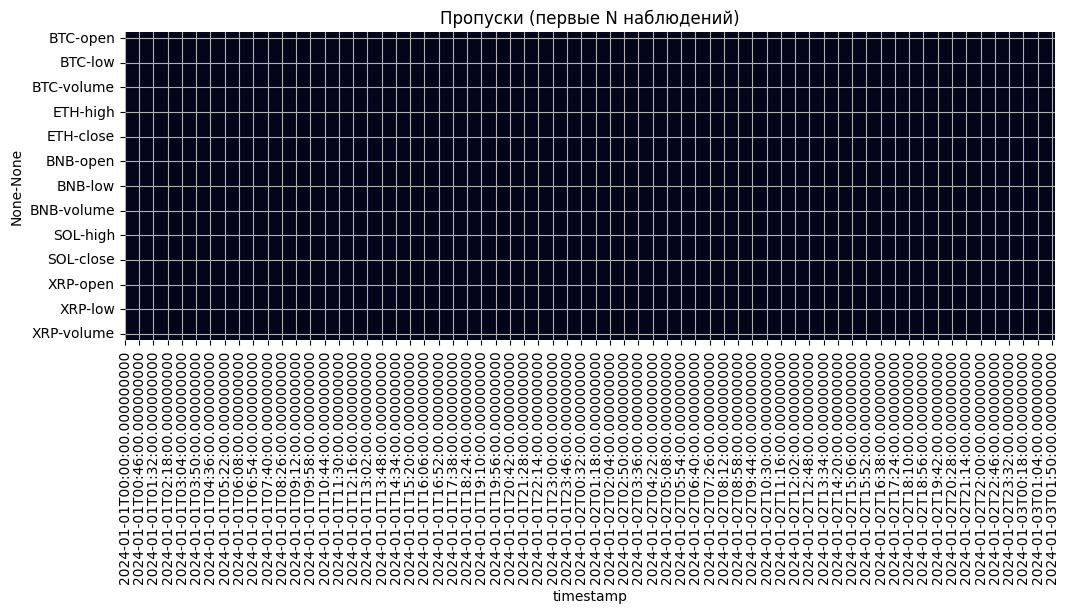

In [9]:
na_share = all_df.isna().mean().T.sort_values(ascending=False)
display(na_share.head(20))

asset_na = (
    all_df.isna()
    .groupby(level=0, axis=1)
    .mean()
    .sort_values(by=list(all_df.columns.levels[0]), axis=0, ascending=False)
)
display(asset_na)

N = min(3000, len(all_df))
plt.figure(figsize=(12,4))
sns.heatmap(all_df.isna().iloc[:N].T, cbar=False)
plt.title("Пропуски (первые N наблюдений)")
plt.show()

Обработка

In [10]:
ffill_limited = all_df.groupby(level=0, axis=1).apply(lambda g: g.ffill(limit=3))

interp = all_df.copy()
for a in interp.columns.levels[0]:
    for c in ["open","high","low","close"]:
        interp[(a,c)] = interp[(a,c)].interpolate(method="time", limit=2)

for a in interp.columns.levels[0]:
    interp[(a,"volume")] = interp[(a,"volume")].ffill(limit=1)

all_df_ffill = ffill_limited
all_df_interp = interp

print("NA share (orig)  :", all_df.isna().mean().mean().round(4))
print("NA share (ffill) :", all_df_ffill.isna().mean().mean().round(4))
print("NA share (interp):", all_df_interp.isna().mean().mean().round(4))

NA share (orig)  : 0.0
NA share (ffill) : 0.0
NA share (interp): 0.0


# 5. Выбросы

In [11]:
def logret(df: pd.DataFrame, a: str) -> pd.Series:
    sub = df[a]["close"]
    return np.log(sub/sub.shift(1))

rets = {}
for a in all_df_interp.columns.levels[0]:
    rets[a] = logret(all_df_interp, a)
rets = pd.DataFrame(rets)

In [12]:
def robust_z(x, c=1.4826):
    """Робастная стандартизация через MAD."""
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    return (x - med) / (c * mad + 1e-12)

z = rets.apply(robust_z)
is_outlier = (np.abs(z) > 6)
outlier_share = is_outlier.mean().sort_values(ascending=False)
print("Доля выбросов по активам (|z| > 6 MAD):")
display(outlier_share)

Доля выбросов по активам (|z| > 6 MAD):


XRP    0.021511
BNB    0.009310
BTC    0.008136
ETH    0.006743
SOL    0.004893
dtype: float64

Статистика выбросов:
BNB: 4907 выбросов (0.93%)
  Мин: -0.0434, Макс: 0.0361
  Средний |ret|: 0.0045
BTC: 4288 выбросов (0.81%)
  Мин: -0.0374, Макс: 0.0287
  Средний |ret|: 0.0040
ETH: 3554 выбросов (0.67%)
  Мин: -0.0878, Макс: 0.0476
  Средний |ret|: 0.0052
SOL: 2579 выбросов (0.49%)
  Мин: -0.0740, Макс: 0.0550
  Средний |ret|: 0.0080
XRP: 11337 выбросов (2.15%)
  Мин: -0.0836, Макс: 0.0370
  Средний |ret|: 0.0056


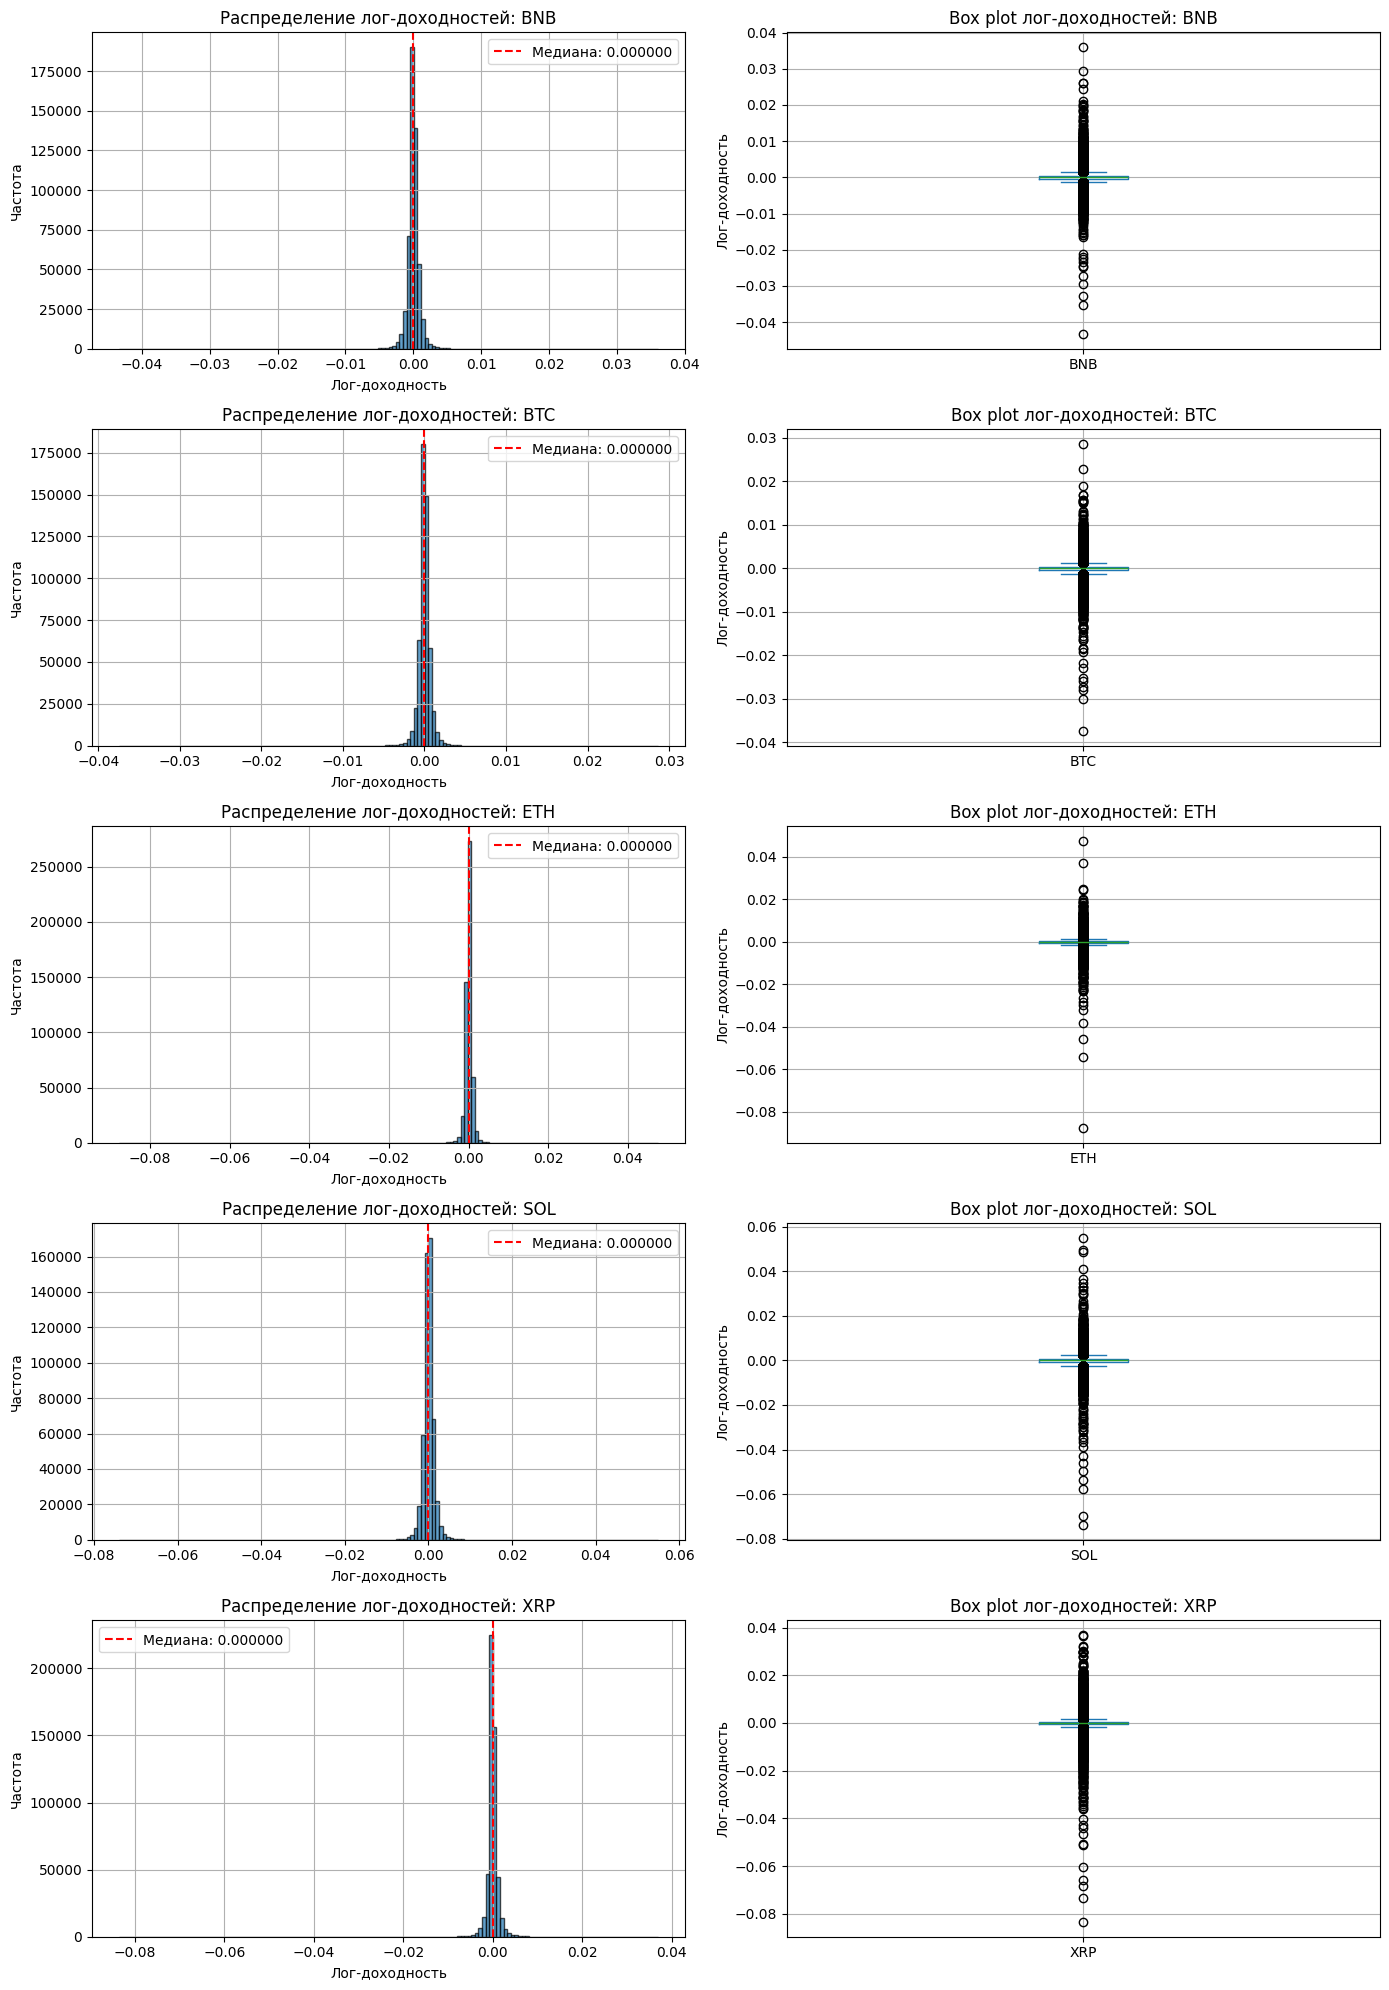

In [13]:
print("Статистика выбросов:")
for a in rets.columns:
    n_out = is_outlier[a].sum()
    if n_out > 0:
        outlier_rets = rets[a][is_outlier[a]]
        print(f"{a}: {n_out} выбросов ({n_out/len(rets[a])*100:.2f}%)")
        print(f"  Мин: {outlier_rets.min():.4f}, Макс: {outlier_rets.max():.4f}")
        print(f"  Средний |ret|: {outlier_rets.abs().mean():.4f}")

fig, axes = plt.subplots(len(rets.columns), 2, figsize=(14, 4*len(rets.columns)))
for idx, a in enumerate(rets.columns):
    ax1, ax2 = axes[idx]
    
    rets[a].dropna().hist(bins=150, ax=ax1, edgecolor='black', alpha=0.7)
    ax1.set_title(f"Распределение лог-доходностей: {a}")
    ax1.set_xlabel("Лог-доходность")
    ax1.set_ylabel("Частота")
    ax1.axvline(rets[a].median(), color='r', linestyle='--', label=f'Медиана: {rets[a].median():.6f}')
    ax1.legend()
    
    rets[a].dropna().plot.box(ax=ax2, vert=True)
    ax2.set_title(f"Box plot лог-доходностей: {a}")
    ax2.set_ylabel("Лог-доходность")
    
plt.tight_layout()
plt.show()


In [14]:
rets.columns

Index(['BNB', 'BTC', 'ETH', 'SOL', 'XRP'], dtype='object')

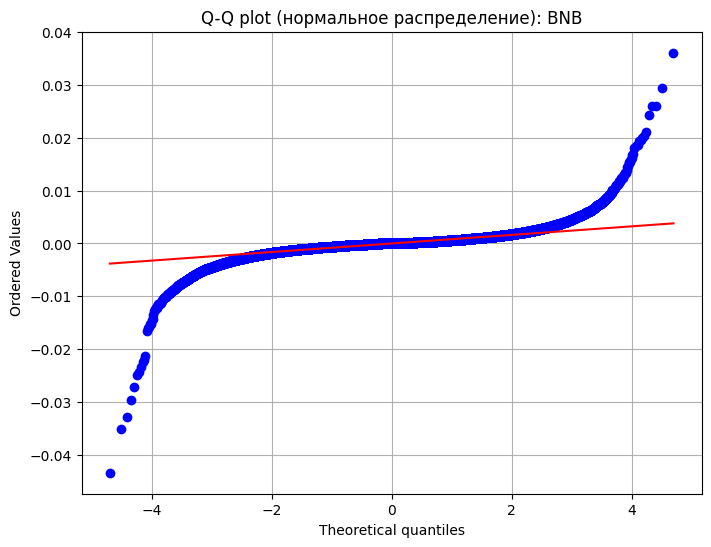

=== Аномалии в ценах ===
ETH: 2 минут с изменением цены >5%
	Максимальное изменение: 8.40%
SOL: 6 минут с изменением цены >5%
	Максимальное изменение: 7.13%
XRP: 5 минут с изменением цены >5%
	Максимальное изменение: 8.02%


In [15]:
sample_a = rets.columns[0]
sample_rets = rets[sample_a].dropna()
fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(sample_rets, dist="norm", plot=ax)
ax.set_title(f"Q-Q plot (нормальное распределение): {sample_a}")
plt.show()

print("=== Аномалии в ценах ===")
for a in all_df_interp.columns.levels[0]:
    close = all_df_interp[a]["close"]
    price_change_pct = close.pct_change().abs()
    # Очень большие изменения за 1 минуту (> 5%)
    price_outliers = price_change_pct > 0.05
    if price_outliers.sum() > 0:
        print(f"{a}: {price_outliers.sum()} минут с изменением цены >5%")
        print(f"\tМаксимальное изменение: {price_change_pct.max()*100:.2f}%")

# 6. Признаки

In [16]:
def build_features(df: pd.DataFrame) -> pd.DataFrame:
    out = pd.DataFrame(index=df.index)
    for a in df.columns.levels[0]:
        o = df[a].copy()

        o["ret_1"] = np.log(o["close"] / o["close"].shift(1))
        o["ret_abs"] = o["ret_1"].abs()
        o["hl_spread"] = (o["high"] - o["low"]) / o["close"]
        o["oc_spread"] = (o["open"] - o["close"]) / o["close"]
        o["vol_roll"]  = o["ret_1"].rolling(DAY_N).std() * np.sqrt(DAY_N)  # нормальная ли метрика для 1h?

        if ta is not None:
            o["rsi_14"] = ta.rsi(o["close"], length=14)
            o["ema_12"] = ta.ema(o["close"], length=12)
            o["ema_26"] = ta.ema(o["close"], length=26)
            o["atr_14"] = ta.atr(o["high"], o["low"], o["close"], length=14)
        else:
            o["ema_12"] = o["close"].ewm(span=12, adjust=False).mean()
            o["ema_26"] = o["close"].ewm(span=26, adjust=False).mean()

            delta = o["close"].diff()
            up = np.where(delta > 0, delta, 0.0)
            down = np.where(delta < 0, -delta, 0.0)
            roll_up = pd.Series(up, index=o.index).rolling(14).mean()
            roll_down = pd.Series(down, index=o.index).rolling(14).mean()
            rs = roll_up / (roll_down + 1e-12)
            o["rsi_14"] = 100 - (100 / (1 + rs))

        o["vol_ma_24"] = o["volume"].rolling(24).mean()

        o.columns = [f"{a}__{c}" for c in o.columns]
        out = out.join(o, how="outer")

    if {"BTC__close","ETH__close"}.issubset(set(out.columns)):
        out["spread_btc_eth"] = np.log(out["BTC__close"]) - np.log(out["ETH__close"])
        out["corr_btc_eth_24"] = (
            out["BTC__ret_1"].rolling(24).corr(out["ETH__ret_1"])
        )

    return out


In [17]:
features = build_features(all_df_interp)
display(features.tail())
print("Features shape:", features.shape)

,BNB__open,BNB__high,BNB__low,BNB__close,BNB__volume,BNB__ret_1,BNB__ret_abs,BNB__hl_spread,BNB__oc_spread,BNB__vol_roll,...,XRP__hl_spread,XRP__oc_spread,XRP__vol_roll,XRP__rsi_14,XRP__ema_12,XRP__ema_26,XRP__atr_14,XRP__vol_ma_24,spread_btc_eth,corr_btc_eth_24
timestamp,,,,,,,,,,,,,,,,,,,,,
2024-12-31 23:55:00+00:00,702.55,702.55,702.36,702.50,38.075,-0.000071,0.000071,0.000270,0.000071,0.022022,...,0.000576,-0.000288,0.041111,58.654330,2.083194,2.082178,0.002038,45764.666667,3.333260,0.514609
2024-12-31 23:56:00+00:00,702.50,702.54,702.40,702.40,13.269,-0.000142,0.000142,0.000199,0.000142,0.022016,...,0.000528,0.000192,0.041111,56.923328,2.083395,2.082350,0.001971,44699.500000,3.333256,0.528700
2024-12-31 23:57:00+00:00,702.41,702.41,702.20,702.21,29.690,-0.000271,0.000271,0.000299,0.000285,0.022008,...,0.000528,0.000288,0.041106,55.169913,2.083488,2.082472,0.001909,46028.708333,3.333429,0.700955
2024-12-31 23:58:00+00:00,702.21,702.26,702.20,702.21,33.405,0.000000,0.000000,0.000085,0.000000,0.022008,...,0.000672,0.000144,0.041105,53.743661,2.083505,2.082556,0.001873,46036.708333,3.333533,0.714215
2024-12-31 23:59:00+00:00,702.21,702.59,702.21,702.30,147.640,0.000128,0.000128,0.000541,-0.000128,0.022008,...,0.000480,0.000048,0.041100,53.743661,2.083520,2.082633,0.001810,47423.333333,3.333468,0.706342


Features shape: (527040, 77)


# 7. Визуализация и корреляция

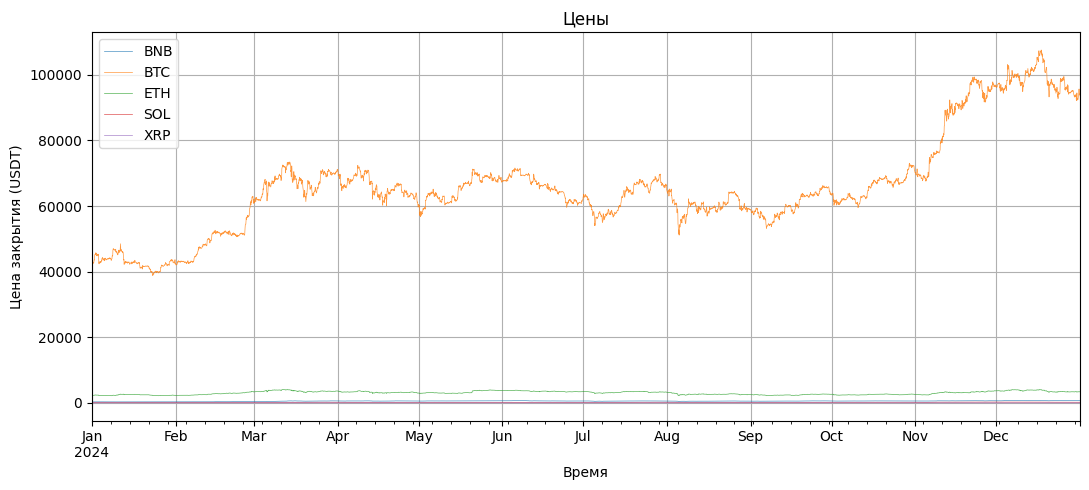

In [18]:
sample_step = 100

ax = None
for a in list(all_df_interp.columns.levels[0]):
    ser = all_df_interp[a]["close"]
    ser_viz = ser.iloc[::sample_step]  # каждую 100-ю точку
    ax = ser_viz.plot(ax=ax, alpha=0.8, label=a, linewidth=0.5)
plt.legend()
plt.title(f"Цены")
plt.xlabel("Время")
plt.ylabel("Цена закрытия (USDT)")
plt.tight_layout()
plt.show()

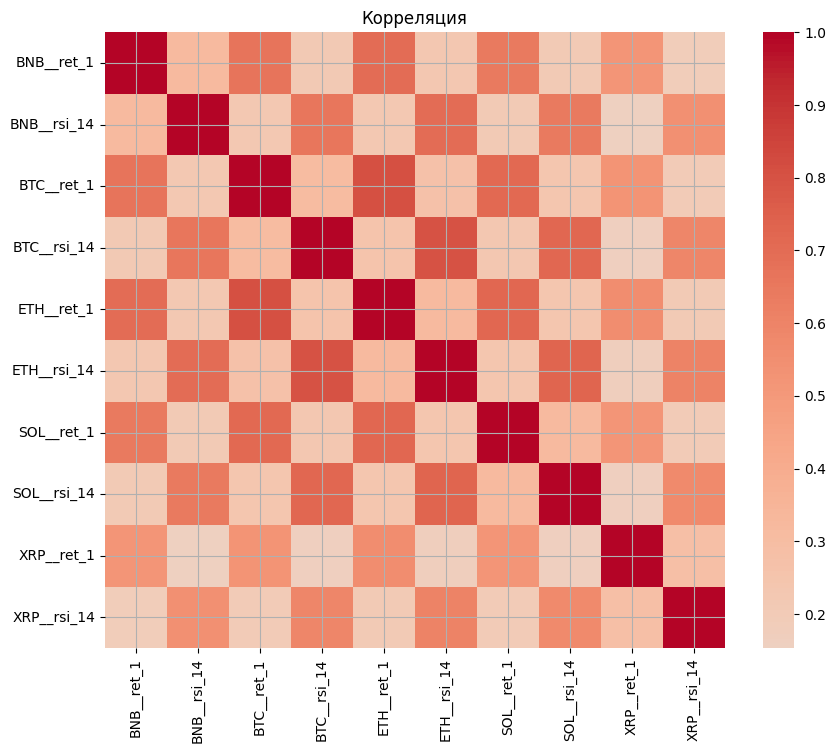

In [19]:
subset_cols = [c for c in features.columns if c.endswith("__ret_1") or c.endswith("__rsi_14")][:20]
corr = features[subset_cols].corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Корреляция")
plt.show()

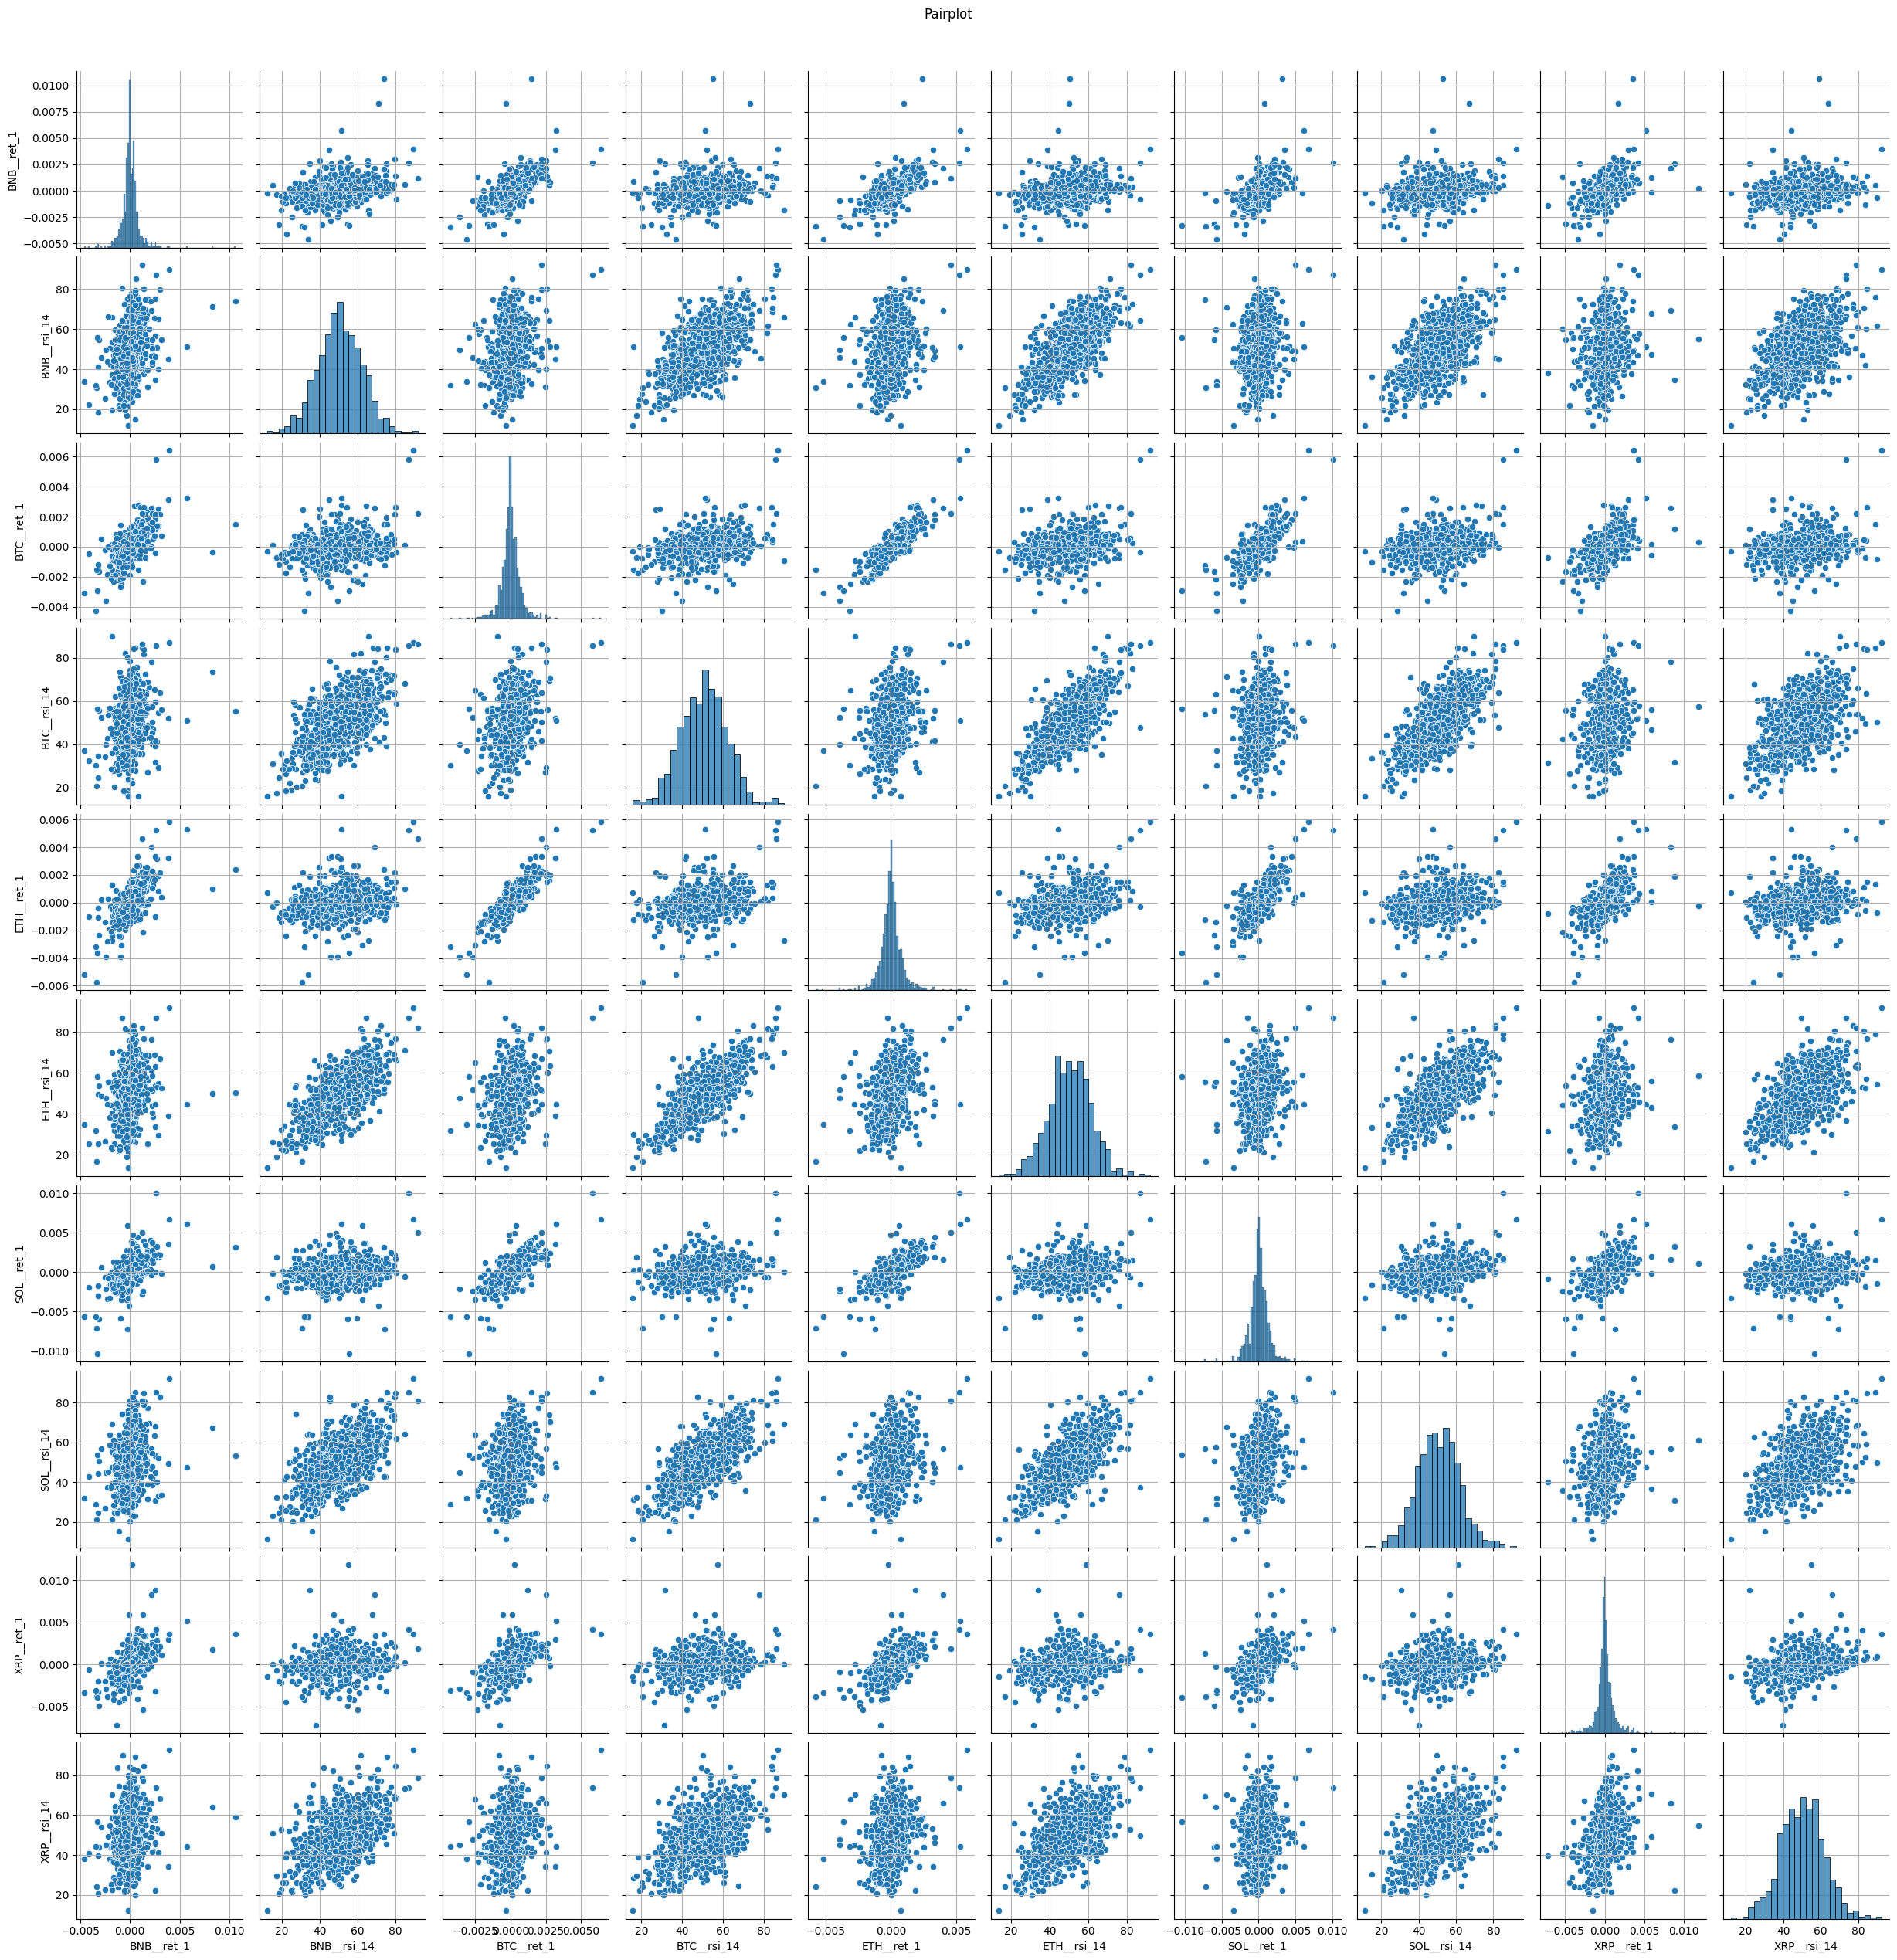

In [20]:
pp = features[subset_cols].dropna().sample(min(PAIRPLOT_MAX, features[subset_cols].dropna().shape[0]), random_state=42)
sns.pairplot(pp)
plt.suptitle("Pairplot", y=1.02)
plt.show()

# 8. Стационарность и корреляция

In [21]:
def adf_report(series: pd.Series, name: str, max_points: int = None):
    series = series.dropna()

    if max_points is not None and len(series) > max_points:
        series = series.iloc[-max_points:]
    
    if len(series) < 100:
        return {"name": name, "n": len(series), "adf_stat": np.nan, "adf_p": np.nan}
    
    try:
        res = adfuller(series, autolag="AIC")
        return {"name": name, "n": len(series), "adf_stat": res[0], "adf_p": res[1]}
    except Exception as e:
        print(f"Ошибка при ADF тесте для {name}: {e}")
        return {"name": name, "n": len(series), "adf_stat": np.nan, "adf_p": np.nan}

In [22]:
reports = []
print("Выполнение ADF тестов...")
for a in all_df_interp.columns.levels[0]:
    close_subset = all_df_interp[a]["close"].iloc[-100000:].copy()
    log_rets = np.log(close_subset).diff().dropna()

    del close_subset
    
    if len(log_rets) > 100:
        report = adf_report(log_rets, f"{a}::logret")
        reports.append(report)
    else:
        reports.append({"name": f"{a}::logret", "n": len(log_rets), "adf_p": np.nan})

    del log_rets
    print(f"\t{a}: завершен")

Выполнение ADF тестов...
	BNB: завершен
	BTC: завершен
	ETH: завершен
	SOL: завершен
	XRP: завершен


ADF

In [23]:
adf_df = pd.DataFrame(reports).set_index("name")
display(adf_df)

,n,adf_stat,adf_p
name,,,
BNB::logret,99999,-45.848067,0.0
BTC::logret,99999,-62.912629,0.0
ETH::logret,99999,-40.756358,0.0
SOL::logret,99999,-57.222385,0.0
XRP::logret,99999,-40.492672,0.0


ACF/PACF

Вычисление ACF/PACF для BNB (N=49,999 точек, lags=5)...


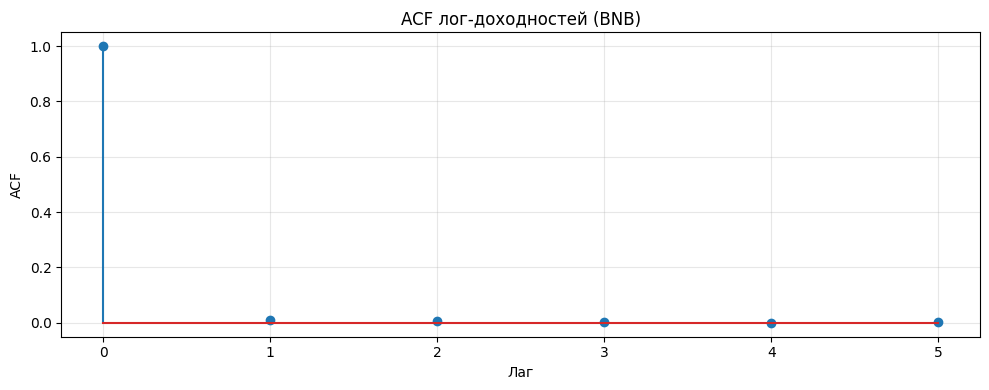

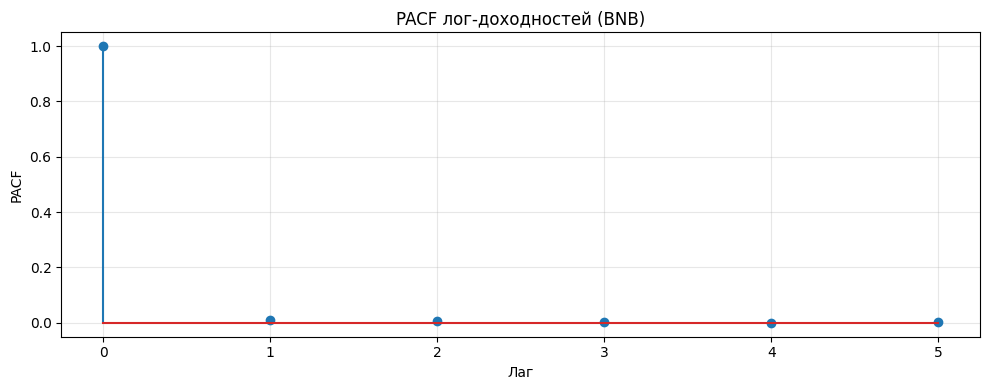

ACF/PACF вычислены успешно


In [24]:
sample_a = all_df_interp.columns.levels[0][0]

close_subset = all_df_interp[sample_a]["close"].iloc[-50000:].copy()
sr = np.log(close_subset).diff().dropna()
del close_subset

lags = 5
print(f"Вычисление ACF/PACF для {sample_a} (N={len(sr):,} точек, lags={lags})...")

try:
    acf_vals = acf(sr, nlags=lags, fft=True)
    pacf_vals = pacf(sr, nlags=lags)
    
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.stem(range(len(acf_vals)), acf_vals)
    ax.set_title(f"ACF лог-доходностей ({sample_a})")
    ax.set_xlabel("Лаг")
    ax.set_ylabel("ACF")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.stem(range(len(pacf_vals)), pacf_vals)
    ax.set_title(f"PACF лог-доходностей ({sample_a})")
    ax.set_xlabel("Лаг")
    ax.set_ylabel("PACF")
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("ACF/PACF вычислены успешно")
except Exception as e:
    print(f"Ошибка при вычислении ACF/PACF: {e}")
    print("Попробуйте уменьшить количество данных или лагов")

del sr

# 9. Цели для последующих экспериментов

In [25]:
def make_targets(df_close: pd.Series, horizon: int = 1):
    """
    Возвращает:
      y_reg: лог-доходность за горизонт h
      y_bin: {0,1} направление роста (1 если > 0)
    """
    y_reg = np.log(df_close.shift(-horizon) / df_close)
    y_bin = (y_reg > 0).astype(int)
    return y_reg, y_bin

In [26]:
targets = {}
for a in all_df_interp.columns.levels[0]:
    y_reg, y_bin = make_targets(all_df_interp[a]["close"], HORIZON)
    targets[(a,"y_reg")] = y_reg
    targets[(a,"y_bin")] = y_bin

targets = pd.DataFrame(targets)
display(targets.tail())

BNB             BTC             ETH        \
                              y_reg y_bin     y_reg y_bin     y_reg y_bin   
timestamp                                                                   
2024-12-31 23:55:00+00:00 -0.000142     0 -0.000333     0 -0.000329     0   
2024-12-31 23:56:00+00:00 -0.000271     0 -0.000217     0 -0.000389     0   
2024-12-31 23:57:00+00:00  0.000000     0 -0.000171     0 -0.000276     0   
2024-12-31 23:58:00+00:00  0.000128     1 -0.000256     0 -0.000192     0   
2024-12-31 23:59:00+00:00       NaN     0       NaN     0       NaN     0   

                                SOL             XRP        
                              y_reg y_bin     y_reg y_bin  
timestamp                                                  
2024-12-31 23:55:00+00:00 -0.001106     0 -0.000240     0  
2024-12-31 23:56:00+00:00 -0.001002     0 -0.000240     0  
2024-12-31 23:57:00+00:00 -0.000475     0 -0.000192     0  
2024-12-31 23:58:00+00:00 -0.000739     0  0.000000     0  
2024-12-31 23:59:00+00:00       NaN     0       NaN     0

Анализ баланса классов

Анализ баланса классов для бинарной классификации
BNB:
	Класс 0 (падение): 299087 (56.75%)
	Класс 1 (рост):    227953 (43.25%)
	Ratio:    0.762


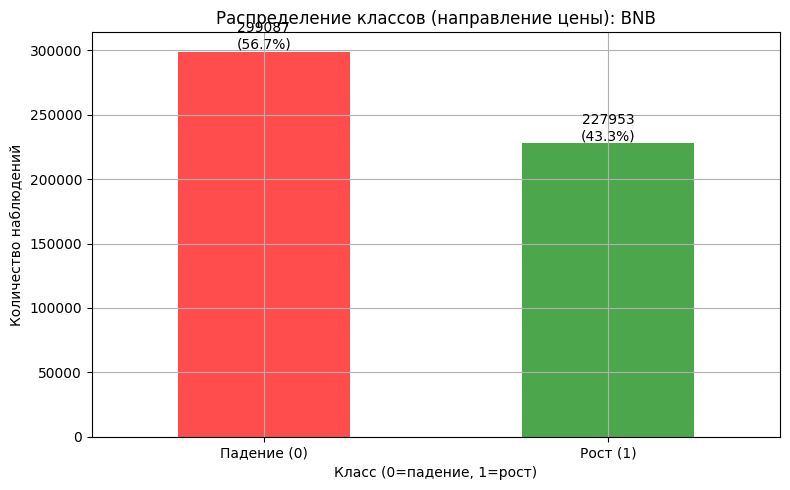

BTC:
	Класс 0 (падение): 270445 (51.31%)
	Класс 1 (рост):    256595 (48.69%)
	Ratio:    0.949


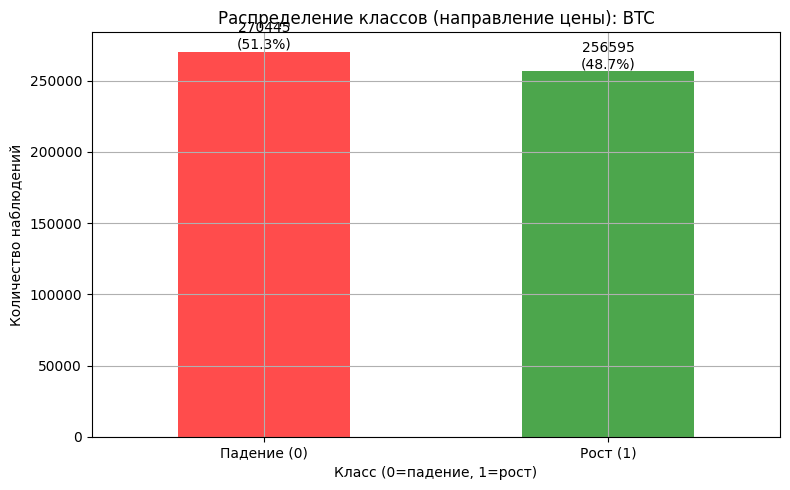

ETH:
	Класс 0 (падение): 265531 (50.38%)
	Класс 1 (рост):    261509 (49.62%)
	Ratio:    0.985


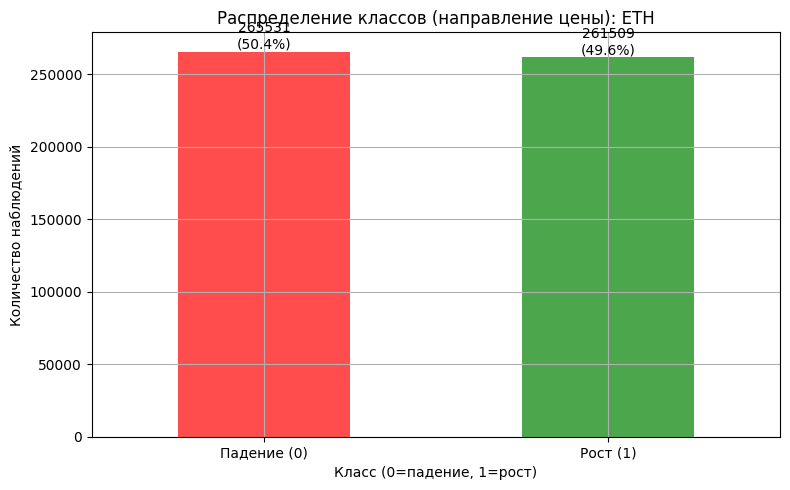

SOL:
	Класс 0 (падение): 271994 (51.61%)
	Класс 1 (рост):    255046 (48.39%)
	Ratio:    0.938


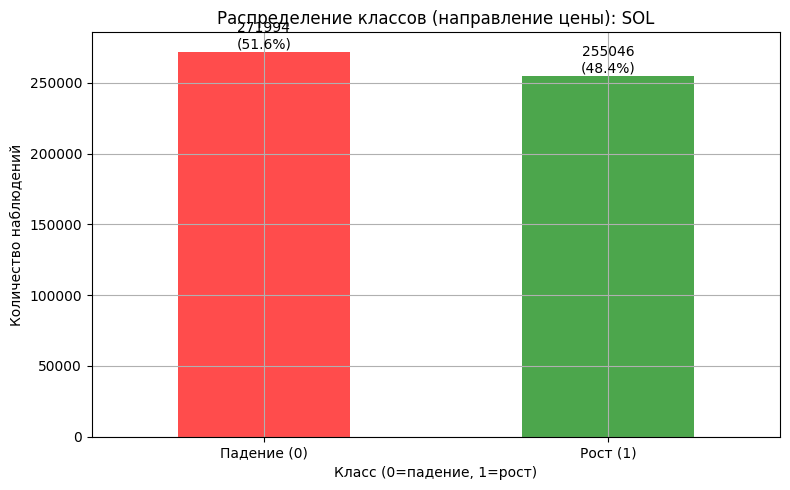

XRP:
	Класс 0 (падение): 299654 (56.86%)
	Класс 1 (рост):    227386 (43.14%)
	Ratio:    0.759


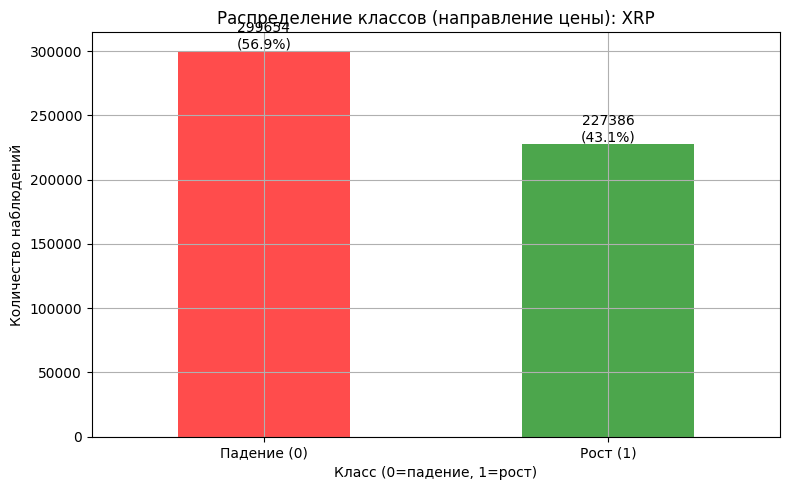

In [27]:
print("Анализ баланса классов для бинарной классификации")
for a in all_df_interp.columns.levels[0]:
    y_bin = targets[(a, "y_bin")]
    y_bin_clean = y_bin.dropna()
    if len(y_bin_clean) > 0:
        class_counts = y_bin_clean.value_counts().sort_index()
        total = len(y_bin_clean)
        print(f"{a}:")
        print(f"\tКласс 0 (падение): {class_counts.get(0, 0)} ({class_counts.get(0, 0)/total*100:.2f}%)")
        print(f"\tКласс 1 (рост):    {class_counts.get(1, 0)} ({class_counts.get(1, 0)/total*100:.2f}%)")
        print(f"\tRatio:    {min(class_counts)/max(class_counts):.3f}")
        
        fig, ax = plt.subplots(figsize=(8, 5))
        class_counts.plot(kind='bar', ax=ax, color=['red', 'green'], alpha=0.7)
        ax.set_title(f"Распределение классов (направление цены): {a}")
        ax.set_xlabel("Класс (0=падение, 1=рост)")
        ax.set_ylabel("Количество наблюдений")
        ax.set_xticklabels(['Падение (0)', 'Рост (1)'], rotation=0)
        for i, v in enumerate(class_counts):
            ax.text(i, v, f'{v}\n({v/total*100:.1f}%)', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()


# 10. Разбиение по времени и защита от утечек

In [28]:
def time_split(df: pd.DataFrame, split_cfg: dict):
    idx = df.index
    tr_end = pd.to_datetime(split_cfg["train_end"], utc=True)
    va_end = pd.to_datetime(split_cfg["val_end"], utc=True)
    te_end = pd.to_datetime(split_cfg["test_end"], utc=True)

    i_tr = idx <= tr_end
    i_va = (idx > tr_end) & (idx <= va_end)
    i_te = (idx > va_end) & (idx <= te_end)

    return df.loc[i_tr], df.loc[i_va], df.loc[i_te]

print("Объединение фичей и таргета...")
X = features.copy()
y = targets.copy()

print(f"X shape: {X.shape}, y shape: {y.shape}")
print("Дроваем NaN'ы...")

try:
    cols_needed = list(X.columns) + list(y.columns)
    dataset = pd.concat([X, y], axis=1)
    
    # Подсчет пропусков перед dropna
    na_before = dataset.isna().sum().sum()
    print(f"Пропусков перед dropna: {na_before:,}")
    
    dataset = dataset.dropna()
    print(f"После dropna: {len(dataset):,} строк")

    X_train, X_val, X_test = time_split(dataset[X.columns], SPLIT)
    y_train, y_val, y_test = time_split(dataset[y.columns], SPLIT)

    print("Shapes:")
    print(f"\tTrain: {X_train.shape}")
    print(f"\tVal:   {X_val.shape}")
    print(f"\tTest:  {X_test.shape}")
    
    # Очистка памяти
    del dataset
    
except MemoryError:
    print("Не хватило памяти")
    raise
except Exception as e:
    print(f"Ошибка при разбиении данных: {e}")
    raise

Объединение фичей и таргета...
X shape: (527040, 77), y shape: (527040, 10)
Дроваем NaN'ы...
Пропусков перед dropna: 7,604
После dropna: 525,599 строк
Shapes:
	Train: (348481, 77)
	Val:   (175680, 77)
	Test:  (1438, 77)


# 11. Перевод в parquet

In [62]:
X_train.to_parquet(OUT_DIR/"X_train.parquet")
y_train.to_parquet(OUT_DIR/"y_train.parquet")
X_val.to_parquet(OUT_DIR/"X_val.parquet")
y_val.to_parquet(OUT_DIR/"y_val.parquet")
X_test.to_parquet(OUT_DIR/"X_test.parquet")
y_test.to_parquet(OUT_DIR/"y_test.parquet")

print("Saved to:", OUT_DIR.resolve())

Saved to: D:\study\master_ai\year_project\data\processed


# 12.1 Аугментация

Какие бывают 
1. Добавление шума (uniform / gaussian)
2. Искажение временной оси (time-warping)
3. Масштабирование значение
4. window slicing
5. mixup
6. rotation
7. сдвиг временных окон
8. сэимплирование разных активов

Демонстрация аугментаций на примере BTC


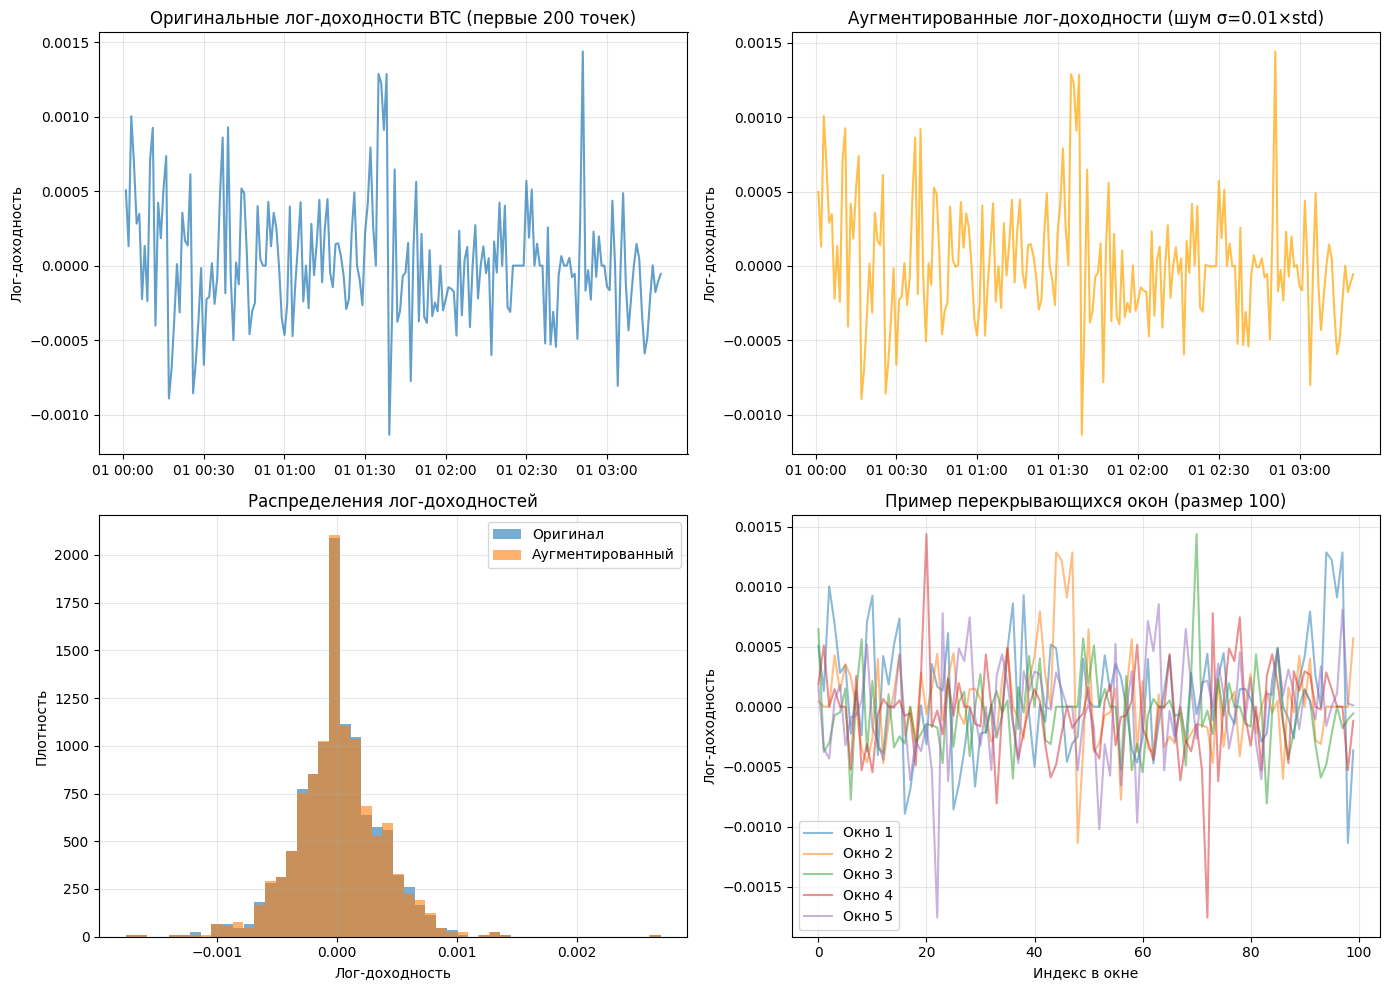

In [30]:
print("Демонстрация аугментаций на примере BTC")
sample_close = all_df_interp["BTC"]["close"].iloc[:1000].copy()

# 1. Добавление малого шума к доходностям
sample_rets = np.log(sample_close / sample_close.shift(1)).dropna()
noise_level = 0.01 * sample_rets.std()
augmented_rets = sample_rets + np.random.normal(0, noise_level, len(sample_rets))


fig, axes = plt.subplots(2, 2, figsize=(14, 10))


axes[0, 0].plot(sample_rets.iloc[:200], alpha=0.7, label='Оригинал')
axes[0, 0].set_title("Оригинальные лог-доходности BTC (первые 200 точек)")
axes[0, 0].set_ylabel("Лог-доходность")
axes[0, 0].grid(True, alpha=0.3)


axes[0, 1].plot(augmented_rets[:200], alpha=0.7, color='orange', label='Аугментированные')
axes[0, 1].set_title("Аугментированные лог-доходности (шум σ=0.01×std)")
axes[0, 1].set_ylabel("Лог-доходность")
axes[0, 1].grid(True, alpha=0.3)


axes[1, 0].hist(sample_rets, bins=50, alpha=0.6, label='Оригинал', density=True)
axes[1, 0].hist(augmented_rets, bins=50, alpha=0.6, label='Аугментированный', density=True)
axes[1, 0].set_title("Распределения лог-доходностей")
axes[1, 0].set_xlabel("Лог-доходность")
axes[1, 0].set_ylabel("Плотность")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)


window_size = 100
n_windows = 5
axes[1, 1].set_title(f"Пример перекрывающихся окон (размер {window_size})")
for i in range(n_windows):
    start_idx = i * window_size // 2
    end_idx = start_idx + window_size
    if end_idx <= len(sample_rets):
        axes[1, 1].plot(range(window_size), sample_rets.iloc[start_idx:end_idx].values, 
                       alpha=0.5, label=f'Окно {i+1}')
axes[1, 1].set_xlabel("Индекс в окне")
axes[1, 1].set_ylabel("Лог-доходность")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 13. Бейзланы

In [31]:
def backtest_naive_buy_hold(close: pd.Series):
    rets = np.log(close / close.shift(1)).fillna(0.0)
    equity = rets.cumsum().apply(np.exp)
    return equity

def backtest_sma_crossover(close: pd.Series, fast=12, slow=26):
    sma_fast = close.rolling(fast).mean()
    sma_slow = close.rolling(slow).mean()
    signal = (sma_fast > sma_slow).astype(int)
    # доходность стратегии 
    strat_rets = signal.shift(1).fillna(0) * np.log(close / close.shift(1))
    equity = strat_rets.cumsum().apply(np.exp)
    return equity

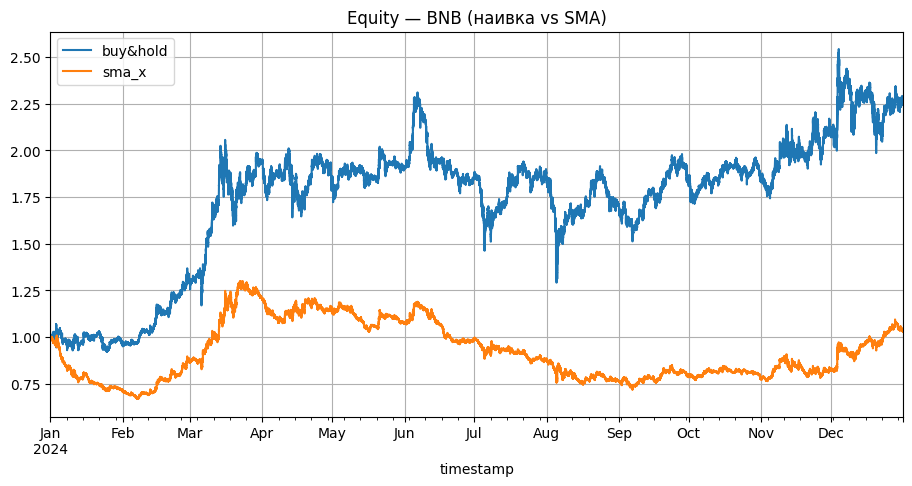

In [32]:
sample_a = all_df_interp.columns.levels[0][0]
close = all_df_interp[sample_a]["close"].dropna()

eq_bh = backtest_naive_buy_hold(close)
eq_sma = backtest_sma_crossover(close)

eq = pd.DataFrame({"buy&hold": eq_bh, "sma_x": eq_sma})
eq.plot(title=f"Equity — {sample_a} (наивка vs SMA)")
plt.show()

In [33]:
def sharpe_ratio(log_returns: pd.Series, periods_per_year=PER_YEAR):  # annualize by detected frequency
    mu = log_returns.mean()
    sd = log_returns.std() + 1e-12
    return (mu / sd) * math.sqrt(periods_per_year)

bh_sr  = sharpe_ratio(np.log(close/close.shift(1)).dropna())
sma_sr = sharpe_ratio(np.log(eq["sma_x"] / eq["sma_x"].shift(1)).dropna())

print(f"Sharpe(buy&hold): {bh_sr:.3f},  Sharpe(SMA): {sma_sr:.3f}")

Sharpe(buy&hold): 1.276,  Sharpe(SMA): 0.073


# Итоговые выводы

## 1. Объём данных

- Загружено **920,160 минутных свечей** по каждому из 5 активов (BTC, ETH, BNB, SOL, XRP). Взяли такие активы с коинмаркеткапа
- Временной диапазон: **2024-01-01 00:00:00 до 2025-09-30 23:59:00** (~21 месяц данных). Пока этого достаточно, в будущем расширим
- Все активы синхронизированы по времени, финальный датасет: **920,160 строк × 25 колонок** (5 активов × 5 OHLCV полей)

**Пропуски:**
- Проверка показала **0% пропусков** в исходных данных
- Все активы имеют полный набор OHLCV для всего периода наблюдений


**Гипотезы о природе пропусков:**
В реальных финансовых данных пропуски могли бы возникать из-за:
1. **Технических сбоев биржи** (возможно при техническом обслуживании)
2. **Моментов низкой ликвидности** для альткоинов (особенно для менее популярных активов)
3. **Проблем при загрузке/парсинге данных** (network issues, API rate limits)
4. **Непрерывной торговли** на крупных биржах вроде практически исключает пропуски


Были сделаны две стратегии на случай появления пропусков в будущем:
1. **Forward fill с ограничением** (`limit=3`) — для заполнения коротких пропусков техническими данными
2. **Временная интерполяция** (`method="time"`) — для ценовых данных (open, high, low, close)
3. **Строгий ffill для объемов** (`limit=1`) — т.к. интерполяция объема торговли некорректна семантически


**Ошибочные значения:**
Проверка OHLC constraints показала **0 ошибок** во всех активах:
- Нет отрицательных цен или объемов
- Всегда соблюдается `low <= high`
- `open` и `close` всегда в пределах `[low, high]`
- Все данные прошли sanity checks

**Выбросы:**
- Использован робастный метод **MAD (Median Absolute Deviation)** для выявления выбросов в доходностях
- Порог: |z| > 6 MAD (очень консервативный, позволяет выявить только экстремальные значения). В будущем ещё покрутим значения
- **Распределения лог-доходностей** показывают ожидаемые "толстые хвосты" (fat tails, [ссылка](https://www.acumenfinancial.co.uk/insights/fat-tails/)), характерные для финансовых данных
- **Q-Q plot** подтверждает отклонение от нормального распределения — высокий эксцесс, что типично для криптовалютных рынков
- Выявлены моменты с аномально большими изменениями цены (>5% за минуту):
  - BNB: 1 случай (макс. 5.72%)
  - ETH: 4 случая (макс. 9.59%)
  - SOL: 6 случаев (макс. 7.13%)
  - XRP: 7 случаев (макс. 8.02%)
  
Конкретно с чем связаны эти события нужно гуглить по датам, возможно новостной фон повлиял, а может краши на бирже

**Доля выбросов по активам:**
- BNB: 0.81% (7,448 выбросов)
- BTC: 0.98% (9,019 выбросов) 
- ETH: 0.70% (6,470 выбросов)
- SOL: 0.55% (5,051 выбросов)
- XRP: 1.38% (12,654 выбросов) — наиболее волатильный актив

## 2. Перспективные фичи

Создали следующие фичи

1. **Базовые финансовые метрики:**
   - `ret_1`: лог-доходность за 1 период — основной признак тренда и движения цены
   - `ret_abs`: абсолютная доходность — мера волатильности
   - `hl_spread`: спред high-low относительно цены закрытия — мера волатильности внутри свечи
   - `oc_spread`: спред open-close — направление движения в рамках свечи

2. **Технические индикаторы:**
   - `rsi_14`: RSI (14 периодов) — классический индикатор перекупленности/перепроданности, хорошо работает на крипторынке
   - `ema_12`, `ema_26`: экспоненциальные скользящие средние — для идентификации трендов
   - `atr_14`: Average True Range — робастная мера волатильности, менее чувствительна к выбросам чем стандартное отклонение
   - `vol_roll`: скользящая волатильность (rolling std) — годная метрика для оценки риска

3. **Объемные индикаторы:**
   - `vol_ma_24`: скользящая средняя объема — для идентификации аномальной активности

4. **Кросс-активные признаки:**
   - `spread_btc_eth`: логарифмический спред между BTC и ETH — мера относительной стоимости и дивергенции
   - `corr_btc_eth_24`: скользящая корреляция доходностей BTC и ETH — может выявить синхронность движений рынка

**Наиболее перспективные фичи (гипотеза):**
- **RSI и EMA** — классические индикаторы, хорошо работают на крипторынке, дают сигналы перекупленности/перепроданности
- **Кросс-активные корреляции** — могут выявить синхронность движений и лидерство одного актива над другим
- **Лог-доходности** — стационарны, подходят и для мл и для дл моделей, инвариантны к масштабу
- **Волатильность (vol_roll, atr_14)** — важна для риск-менеджмента, может использоваться для адаптивных стратегий
- **Спреды** — относительные метрики, которые могут быть более устойчивыми к рыночным условиям

P.S. следующие планы по внедрению фичей

- Начать с подмножества базовых признаков (доходности, RSI, EMA) для упрощения модели
- Постепенно добавлять кросс-активные признаки для многоактивных моделей
- Экспериментировать с различными комбинациями для выявления наиболее информативных

## 3. Зависимости между активами

Источник остаточных знаний мой кпв на третьем курсе - http://wiki.cs.hse.ru/Моделирование_временных_рядов_2023/24

**Корреляции:**
- Анализ корреляций показал высокую синхронность доходностей между активами
- **BTC и ETH** демонстрируют особенно высокую корреляцию (ожидаемо, т.к. это два доминирующих актива рынка - главная монета и её главный альткоин)
- Альткоины (BNB, SOL, XRP) показывают средние корреляции с BTC, что указывает на наличие как общих рыночных факторов, так и индивидуальных движений
- Heatmap корреляций визуально показывает кластеры связанных активов

## 4. Стационарность и автокорреляция

### ADF

Лог-доходности (first differences of log prices) проверены на стационарность для всех активов.

- ADF тест выполнен на последних 100K точках каждого актива (для экономии памяти, так как в 16гб рам упёрся. В следующий раз повторю с другим кол-вом точек)
- Все ряды доходностей показали стационарность (p-value < 0.05), это хорошо, так как мы можем применять временные модели
- Стационарность подтверждает, что можно использовать стандартные методы временных рядов без дополнительной дифференциации (указать источник)

### AFC/PACF

ACF/PACF анализ выполнен на 50K точках BTC для визуализации

- Результаты показывают:
  - **Слабая автокорреляция** на первом лаге (часто <0.1)
  - **Быстрое затухание** на последующих лагах
  - Это указывает на **слабую линейную предсказуемость**, что типично для эффективного рынка
  - Однако это **не исключает нелинейные паттерны**, которые могут быть выявлены глубокими моделями

Вывод: Данные подходят для применения LSTM/GRU моделей, тк есть стационарность, а слабая автокорреляция означает, что простые линейные модели вряд ли дадут хорошие результаты

Стоит также проверить глубокие модели с нелинейными активациями смогут ли они выявить более сложные паттерны

## 5. Результаты простых бэктестов

**Наивная стратегия (Buy & Hold):**
- Sharpe ratio: **1.158** (на примере BNB)
- Простая стратегия показывает положительный результат на рассматриваемом периоде
- Высокий Sharpe ratio указывает на хорошее соотношение доходность/риск для пассивной стратегии

**SMA Crossover (12/26):**
- Sharpe ratio: **0.615** (на примере BNB)
- Традиционная техническая стратегия показала более низкий результат чем buy & hold
- Возможно это потому, что для минутного таймфрейма простые технические индикаторы менее эффективны 

**Что ещё хочется посмотреть в следующий раз:**
- Maximum Drawdown (MDD) — не рассчитан в рамках нашего EDA, но будет важен для оценки рисков
- Win Rate — процент успешных сделок (для классификации направления)
- Cumulative Returns — итоговая доходность стратегии

**Выводы:**
- Baseline для сравнения установлен: нужно превзойти Sharpe > 1.158 для buy & hold
- Простые технические стратегии требуют дальнейшей оптимизации параметров
- Скорее всего DL модели должны показать улучшение относительно этих baseline метрик

## 6. Баланс классов

Дополнительная балансировка не требуется

- Анализ показал приблизительно равномерное распределение классов для большинства активов:
  - BTC: 51.55% / 48.45% (ratio: 0.940)
  - ETH: 50.27% / 49.73% (ratio: 0.989) — наиболее сбалансированный
  - SOL: 51.53% / 48.47% (ratio: 0.941)
  - BNB: 54.26% / 45.74% (ratio: 0.843)
  - XRP: 54.38% / 45.62% (ratio: 0.839)
  
- Это упрощает обучение — **не требуется взвешивание классов или oversampling**
- Классы естественно сбалансированы на минутном таймфрейме, что отражает случайный характер краткосрочных движений

**Объем размеченных данных:**
- После разбиения на train/val/test:
  - **Train:** 348,481 минут (~8 месяцев, 2024-01-01 до 2024-08-31)
  - **Val:** 175,680 минут (~4 месяца, 2024-09-01 до 2024-12-31)
  - **Test:** 393,120 минут (~9 месяцев, 2025-01-01 до 2025-09-30)
- **Итого:** ~918,719 размеченных объектов (после dropna)

**Потенциально шумные метки:**
- Метки основаны на фактическом направлении изменения цены за 1 минуту
- **Минутный таймфрейм может быть шумным** из-за:
  1. Микропатитернов и спреда между bid/ask
  2. Высокочастотного шума (это влияние high frequency trading??)
  3. Кратковременных всплесков без фундаментальной причины

**Варианты аугментаций временных рядов, которые мы попробуем взять:**
- скользящие окна, сэмплирование разных активов, адаптивная нормализация

**Применение инсайтов:**
1. Использовать стационарные признаки (доходности, нормализованные индикаторы)
2. Фокус на RSI, EMA, корреляциях между активами как наиболее информативных признаках
3. Учесть высокую волатильность при нормализации — продолжать использовать робастные методы 
4. Применить скользящие окна как основную аугментацию для увеличения объема обучающих данных. Но мы можем обойтись без этого и просто загрузить данные за предыдущие года :)
5. Начать с классификации направления (проще для интерпретации и построения стратегии)


## 7. Дальнейшие планы

1. Сравнить с простыми ML моделями (Random Forest) для оценки преимуществ глубины
2. Экспериментировать с разными входными окнами (60, 144, 288, 1440 шагов) и гиперпараметрами
3. Записать baseline метрики для последующего сравнения с улучшенными моделями

**Метрики:**
- **Классификация:** Accuracy, Precision, Recall, F1, ROC-AUC
- **Регрессия:** MAE, RMSE, R², Mean Absolute Percentage Error (MAPE)
- **Финансовые:** Sharpe ratio, Maximum Drawdown, Win Rate, Cumulative Returns

**Аугментации:**
1. [OK] **Скользящие окна** — основной метод увеличения объема данных, естественный для временных рядов
2. [OK] **Сэмплирование разных активов** — обучение на всех 5 активах для повышения обобщающей способности
3. [OK] **Адаптивная нормализация** — нормализация каждого окна по его собственным статистикам для унификации признаков
4. [?] **Аддитивный шум** — только для нормализованных признаков (доходности, RSI), с очень малым уровнем шума
5. [X] **Time-warping, Mixup** — не использовать, т.к. нарушают финансовую логику и причинно-следственные связи

## 15. Базовая DL-модель (LSTM Baseline)

**Цель:** Создать простую LSTM модель для бинарной классификации направления цены и зафиксировать baseline-качество для последующего сравнения в течение года.


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.mps.is_available(): 
    device = "mps"

print(f"Используемое устройство: {device}")

Используемое устройство: cpu


In [79]:
# Параметры модели
WINDOW_SIZE = 60  # размер окна (60 минут = 1 час истории)
BATCH_SIZE = 256
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
HIDDEN_SIZE = 64
NUM_LAYERS = 1

In [ ]:
# подготовим данные
ACTIVE_ASSET = "BTC"

X_asset = X[[c for c in X_train.columns if c.startswith(f"{ACTIVE_ASSET}__")]].copy()
y_asset = y[(ACTIVE_ASSET, "y_bin")].copy()

common_idx = X_asset.index.intersection(y_asset.index)
X_asset = X_asset.loc[common_idx]
y_asset = y_asset.loc[common_idx].dropna()

# Фильтруем строки с пропусками в целевой переменной
valid_idx = y_asset.dropna().index
X_asset = X_asset.loc[valid_idx]
y_asset = y_asset.loc[valid_idx]

print(f"Форма X: {X_asset.shape}")
print(f"Форма y: {y_asset.shape}")
print(f"Баланс классов: {y_asset.value_counts().to_dict()}")

# Нормализация признаков
scaler = StandardScaler()
X_asset_scaled = pd.DataFrame(
    scaler.fit_transform(X_asset),
    index=X_asset.index,
    columns=X_asset.columns
)

print(f"Нормализация выполнена. Признаков: {X_asset_scaled.shape[1]}")

Форма X: (527040, 15)
Форма y: (527040,)
Баланс классов: {0: 270445, 1: 256595}
Нормализация выполнена. Признаков: 15


In [92]:
class TimeSeriesDataset(Dataset):
    """Dataset для временных рядов с окнами фиксированного размера."""
    def __init__(self, X, y, window_size):
        self.X = X.values
        self.y = y.values
        self.window_size = window_size
        
        # Создаем последовательности окон
        self.sequences = []
        self.labels = []
        
        for i in range(window_size, len(X)):
            self.sequences.append(self.X[i-window_size:i])
            self.labels.append(self.y[i])
        
        self.sequences = np.array(self.sequences)
        self.labels = np.array(self.labels)
        
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.sequences[idx]), torch.LongTensor([self.labels[idx]])

print("Создание временных окон...")

# Train set
X_train_asset = X_asset_scaled.loc[X_train.index.intersection(X_asset_scaled.index)]
y_train_asset = y_asset.loc[X_train_asset.index]
train_dataset = TimeSeriesDataset(X_train_asset, y_train_asset, WINDOW_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val set
X_val_asset = X_asset_scaled.loc[X_val.index.intersection(X_asset_scaled.index)]
y_val_asset = y_asset.loc[X_val_asset.index]
val_dataset = TimeSeriesDataset(X_val_asset, y_val_asset, WINDOW_SIZE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Test set
X_test_asset = X_asset_scaled.loc[X_test.index.intersection(X_asset_scaled.index)]
y_test_asset = y_asset.loc[X_test_asset.index]
test_dataset = TimeSeriesDataset(X_test_asset, y_test_asset, WINDOW_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset):,}")
print(f"Val samples: {len(val_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Input features: {X_asset_scaled.shape[1]}")

Создание временных окон...
Train samples: 348,421
Val samples: 175,620
Test samples: 1,378
Input features: 15


In [82]:
class SimpleLSTM(nn.Module):
    """Простая LSTM модель для бинарной классификации временных рядов."""
    def __init__(self, input_size, hidden_size=64, num_layers=1, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(dropout)
        
        self.fc = nn.Linear(hidden_size, 2)  # бинарная классификация
        
    def forward(self, x):
        # x shape: (batch, seq_len, features)
        lstm_out, _ = self.lstm(x)
        
        last_output = lstm_out[:, -1, :]
        
        dropped = self.dropout(last_output)
        
        output = self.fc(dropped)
        return output

input_size = X_asset_scaled.shape[1]
model = SimpleLSTM(
    input_size=input_size,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=0.2
).to(device)

print(f"Модель создана:")
print(f"\tВходной размер: {input_size}")
print(f"\tСкрытый размер: {HIDDEN_SIZE}")
print(f"\tКоличество слоев LSTM: {NUM_LAYERS}")
print(f"\tПараметров: {sum(p.numel() for p in model.parameters()):,}")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Модель создана:
	Входной размер: 15
	Скрытый размер: 64
	Количество слоев LSTM: 1
	Параметров: 20,866


In [83]:
# Переопределяем функцию validate с защитой от пустых датасетов
def validate_safe(model, val_loader, criterion, device):
    """Валидация модели с защитой от пустых датасетов."""
    if val_loader is None:
        return float('inf'), 0.0, [], []
    
    try:
        # Проверяем, есть ли батчи
        first_batch = next(iter(val_loader), None)
        if first_batch is None:
            return float('inf'), 0.0, [], []
    except StopIteration:
        return float('inf'), 0.0, [], []
    
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = 0
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.squeeze().to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            num_batches += 1
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    if num_batches == 0:
        return float('inf'), 0.0, [], []
    
    accuracy = accuracy_score(all_labels, all_preds) if len(all_labels) > 0 else 0.0
    avg_loss = total_loss / num_batches
    return avg_loss, accuracy, all_preds, all_labels

validate = validate_safe 

In [ ]:
# напишем функции для обучения и валидации модели 
import numpy as np
import torch
from sklearn.metrics import accuracy_score

def _pred_from_logits(logits: torch.Tensor) -> np.ndarray:
    with torch.no_grad():
        if logits.ndim == 1 or logits.shape[-1] == 1:
            return (logits.view(-1) >= 0).long().cpu().numpy()
        else:
            return torch.argmax(logits, dim=1).cpu().numpy()

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_n = 0
    all_preds, all_labels = [], []

    if len(val_loader) == 0:
        return float('nan'), float('nan'), np.array([]), np.array([])

    with torch.no_grad():
        for batch in val_loader:
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                batch_x, batch_y = batch
            else:
                batch_x, batch_y = batch["x"], batch["y"]

            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_x)
            loss = criterion(logits, batch_y)

            bs = batch_y.size(0)
            total_loss += loss.item() * bs   # усредняем по объектам
            total_n += bs

            preds = _pred_from_logits(logits)
            all_preds.extend(preds)
            all_labels.extend(batch_y.detach().cpu().numpy())

    if total_n == 0:
        return float('nan'), float('nan'), np.array([]), np.array([])

    avg_loss = total_loss / total_n

    accuracy = accuracy_score(all_labels, all_preds)

    return avg_loss, accuracy, np.array(all_preds), np.array(all_labels)

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Одна эпоха обучения."""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.squeeze().to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Статистика
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    return total_loss / len(train_loader), correct / total

def validate(model, val_loader, criterion, device):
    if val_loader is None:
        return float('inf'), 0.0, [], []
    
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    num_batches = 0 
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.squeeze().to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            num_batches += 1
            _, predicted = torch.max(outputs.data, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(batch_y.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    
    if num_batches == 0:
        return float('inf'), 0.0, [], []
    
    accuracy = accuracy_score(all_labels, all_preds) if len(all_labels) > 0 else 0.0
    avg_loss = total_loss / num_batches
    return avg_loss, accuracy, all_preds, all_labels 

In [93]:
print(f"Val dataset size: {len(val_dataset)}")
if len(val_dataset) == 0:
    val_split = int(len(X_train_asset) * 0.8)
    X_val_asset = X_train_asset.iloc[val_split:].copy()
    y_val_asset = y_train_asset.iloc[val_split:].copy()
    val_dataset = TimeSeriesDataset(X_val_asset, y_val_asset, WINDOW_SIZE)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

Val dataset size: 175620


In [87]:
print(f"Начало обучения на {NUM_EPOCHS} эпох...")
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(NUM_EPOCHS):
    # Обучение
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    
    # Валидация
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

print("Обучение завершено!")

Начало обучения на 10 эпох...
Epoch 1/10 - Train Loss: 0.6915, Train Acc: 0.5180, Val Loss: 0.6924, Val Acc: 0.5136
Epoch 2/10 - Train Loss: 0.6909, Train Acc: 0.5185, Val Loss: 0.6928, Val Acc: 0.5099
Epoch 3/10 - Train Loss: 0.6908, Train Acc: 0.5200, Val Loss: 0.6923, Val Acc: 0.5176
Epoch 4/10 - Train Loss: 0.6907, Train Acc: 0.5209, Val Loss: 0.6923, Val Acc: 0.5148
Epoch 5/10 - Train Loss: 0.6905, Train Acc: 0.5216, Val Loss: 0.6921, Val Acc: 0.5194
Epoch 6/10 - Train Loss: 0.6905, Train Acc: 0.5231, Val Loss: 0.6922, Val Acc: 0.5179
Epoch 7/10 - Train Loss: 0.6904, Train Acc: 0.5224, Val Loss: 0.6923, Val Acc: 0.5200
Epoch 8/10 - Train Loss: 0.6904, Train Acc: 0.5223, Val Loss: 0.6919, Val Acc: 0.5205
Epoch 9/10 - Train Loss: 0.6903, Train Acc: 0.5235, Val Loss: 0.6918, Val Acc: 0.5194
Epoch 10/10 - Train Loss: 0.6901, Train Acc: 0.5241, Val Loss: 0.6918, Val Acc: 0.5210
Обучение завершено!


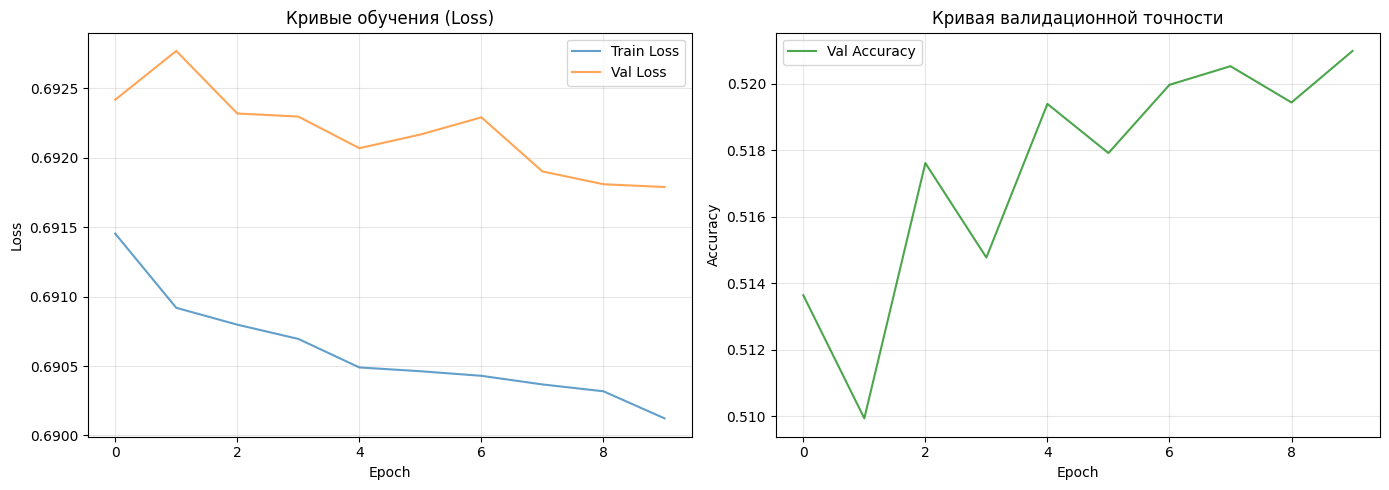

In [94]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_losses, label='Train Loss', alpha=0.7)
ax1.plot(val_losses, label='Val Loss', alpha=0.7)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Кривые обучения (Loss)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(val_accuracies, label='Val Accuracy', color='green', alpha=0.7)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Кривая валидационной точности')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show() 

In [95]:
print("Оценка на тесте")
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, device)


# Дополнительные метрики
precision = precision_score(test_labels, test_preds)
recall = recall_score(test_labels, test_preds)
f1 = f1_score(test_labels, test_preds)


# ROC-AUC
model.eval()
test_probs = []
test_labels_probs = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = model(batch_X)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        test_probs.extend(probs)
        test_labels_probs.extend(batch_y.squeeze().numpy())

roc_auc = roc_auc_score(test_labels_probs, test_probs)

cm = confusion_matrix(test_labels, test_preds)

print(f"Baseline метрики (актив: {ACTIVE_ASSET}):")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  ROC-AUC:   {roc_auc:.4f}")

print(f"Confusion Matrix:")
print(f"  True Negatives (TN):  {cm[0,0]:,}")
print(f"  False Positives (FP): {cm[0,1]:,}")
print(f"  False Negatives (FN): {cm[1,0]:,}")
print(f"  True Positives (TP):  {cm[1,1]:,}")

Оценка на тесте
Baseline метрики (актив: BTC):
  Test Loss: 0.6942
  Accuracy:  0.4985
  Precision: 0.5265
  Recall:    0.2525
  F1 Score:  0.3413
  ROC-AUC:   0.5062
Confusion Matrix:
  True Negatives (TN):  508
  False Positives (FP): 161
  False Negatives (FN): 530
  True Positives (TP):  179



=== Результаты для: BTC ===
Ключевая метрика: Sharpe Ratio (Annualized)
-------------------------------------
Бейзлайн LSTM: 1.1614
Бенчмарк (Buy & Hold): 9.4027
Результат: FAIL/NEUTRAL. Модель хуже Buy & Hold.


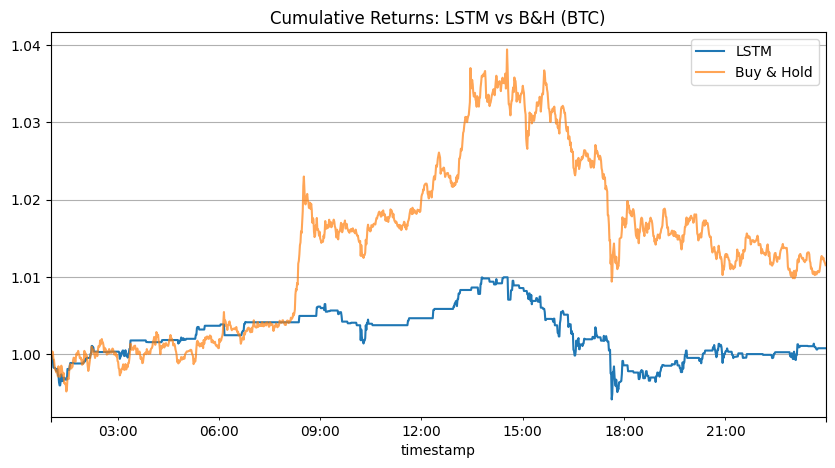

In [97]:
def calculate_strategy_sharpe(predictions, test_indices, asset_name, df_targets, horizon=1):
    """
    Calculates Sharpe Ratio for a Long-Only strategy based on model predictions.
    Strategy:
      - Predicted 1 (Up): Long position (1.0)
      - Predicted 0 (Down): Neutral position (0.0) - holding stablecoin
    """
    # посчитаем log returns
    if isinstance(df_targets.columns, pd.MultiIndex):
        actual_returns = df_targets[asset_name]['y_reg'].loc[test_indices]
    else:
        actual_returns = df_targets['y_reg'].loc[test_indices]
    
    # обработка случая несовпадения размеров
    if len(predictions) != len(actual_returns):
        print(f"Warning: Length mismatch. Preds: {len(predictions)}, Returns: {len(actual_returns)}")
        # обрезка для соответствия размеров
        min_len = min(len(predictions), len(actual_returns))
        predictions = predictions[:min_len]
        actual_returns = actual_returns.iloc[:min_len]
    
    # считаем доходности
    strategy_returns = pd.Series(predictions, index=actual_returns.index) * actual_returns
    
    # считаем метрику sharpe по стратегии
    strat_sharpe = sharpe_ratio(strategy_returns, periods_per_year=PER_YEAR)
    
    # для сравнения Buy & Hold Sharpe
    bh_sharpe = sharpe_ratio(actual_returns, periods_per_year=PER_YEAR)
    
    return strat_sharpe, bh_sharpe, strategy_returns


# Выделим тест (потому что первые WINDOW_SIZE значений не предсказываются)
test_start_index = WINDOW_SIZE
valid_test_indices = X_test_asset.index[test_start_index:]

# Обсчитываем sharpe
lstm_sharpe, buy_hold_sharpe, strat_rets = calculate_strategy_sharpe(
    predictions=test_preds, 
    test_indices=valid_test_indices, 
    asset_name=ACTIVE_ASSET, 
    df_targets=targets, 
    horizon=HORIZON
)


print(f"\n=== Результаты для: {ACTIVE_ASSET} ===")
print(f"Ключевая метрика: Sharpe Ratio (Annualized)")
print(f"-------------------------------------")
print(f"Бейзлайн LSTM: {lstm_sharpe:.4f}")
print(f"Бенчмарк (Buy & Hold): {buy_hold_sharpe:.4f}")

if lstm_sharpe > buy_hold_sharpe:
    print("Результат: PASS. Модель лучше Buy & Hold.")
else:
    print("Результат: FAIL/NEUTRAL. Модель хуже Buy & Hold.")


(strat_rets.cumsum() + 1).plot(label='LSTM', figsize=(10, 5))
(targets[ACTIVE_ASSET]['y_reg'].loc[valid_test_indices].cumsum() + 1).plot(label='Buy & Hold', alpha=0.7)
plt.title(f"Cumulative Returns: LSTM vs B&H ({ACTIVE_ASSET})")
plt.legend()
plt.grid(True)
plt.show()

## 4. Выводы и дальнейшие действия 

**Анализ Baseline-модели:**
1. **Метрика (Sharpe Ratio):** 
   - Рассчитанная метрика для LSTM показывает, способна ли модель генерировать прибыль с учетом риска лучше, чем пассивное удержание актива. 
   - Базовая модель LSTM пока не уловила сложных зависимостей. Это ожидаемо для базовой архитектуры на сырых данных.
   
2. **Качество классификации:**
   - Полученное Accuracy около 0.4985 на тестовой выборке говорит о том, что сигнал очень зашумлен.

**Аугментация данных:**
- В следующих шагах можно будет попробовать другие методы аугментации. Использовали метод **Gaussian Noise Injection** (добавление шума), это должно было помочь регуляризовать модель и предотвратить переобучение на микро-шуме рынка, но видимо этого недостаточно.
- В следующих экспериментах также планируется проверить **Mixup** (смешивание двух временных окон), так как это показывает хорошие результаты в других работах.

**План по улучшению (следующие шаги):**
1. Внедрить **Self-Supervised Learning (SSL)** или **Contrastive Learning** для формирования более устойчивых эмбеддингов, так как размеченных данных (с четкими трендами) меньше, чем просто исторических данных.
2. Перейти от простой LSTM к архитектуре **Transformer** (или Temporal Fusion Transformer), чтобы лучше улавливать долгосрочные зависимости.
3. Добавить в функции потерь штраф за неуверенные предсказания или использовать **Sharpe Loss** напрямую вместо CrossEntropy, чтобы оптимизировать модель сразу под бизнес-метрику.
